In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Astonishingly there seems to be no clean way to set up the Python path automatically for a script that does not
# reside in the root folder. This will need to be added to all notebooks unless a better solution comes along.
import os, sys
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from collections import namedtuple
from copy import copy, deepcopy
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import scipy

import scikits.bootstrap as bootstrap
from scikits.bootstrap.bootstrap import InstabilityWarning
import warnings
# ntraft: Filter all warnings of type InstabilityWarning from the bootstrap library.
warnings.filterwarnings('ignore', category=InstabilityWarning)

from utils import load_yaml

sns.set_theme(style="whitegrid")

# Utility Functions

## Data Loading Functions

In [3]:
from tqdm import tqdm


def load_dataframes(eval_folder, verbose=False):
    """
    Given a folder with a number of pickled dataframes, load and return all of them.
    """
    if verbose:
        print(f"Loading from: {eval_folder.name}")
    all_frames = [pd.read_pickle(f) for f in eval_folder.glob("*.pkl")]
    if verbose:
        print(f"Loaded {len(all_frames)} dataframes for {eval_folder.name}.")
    return all_frames


def load_eval_data(eval_folder, verbose=False):
    """
    Given a folder with a number of pickled dataframes, load all results into a single dataframe.
    """
    all_frames = load_dataframes(eval_folder)  # Don't need the verbose flag here b/c the same info is printed below.
    if all_frames:
        all_data = pd.concat(all_frames)
    else:
        all_data = pd.DataFrame()
    if verbose:
        name = eval_folder.parent.name + "/" + eval_folder.name
        print(f"{name}: Loaded {len(all_frames)} dataframes for total size = {all_data.shape}")
    return all_data


def get_dataset_name(cfg):
    """
    Get the corrected name of the dataset specified in the given config.
    """
    if cfg["dataset"] == "omniimage":
        # Update OmniImage dataset name to disambiguate between different parameterizations.
        return "omniimage" + str(cfg["imgs_per_class"])
    return cfg["dataset"]


PreTrainData = namedtuple("PreTrainData", ["src_name", "target_name", "dflt"])
PRETRAIN_METADATA = [
    PreTrainData("model_name", "model_name", "n/a"),
    PreTrainData("dataset", "train_dataset", "n/a"),
    PreTrainData("train_method", "train_method", "n/a"),
    PreTrainData("lobotomize", "zap", False),
    PreTrainData("lobo_rate", "zap_rate", 0),
    PreTrainData("lobo_size", "zap_size", 0),
    PreTrainData("lobo_biased_steps", "zap_biased_steps", 0),
    PreTrainData("lobo_biased_params", "zap_biased_params", 0),
    PreTrainData("lobo_biased_fraction", "zap_biased_fraction", 0),
    PreTrainData("lr", "train_lr", 0.0),  # Avoid name collision with transfer learning rate.
    PreTrainData("inner_lr", "inner_lr", 0.0),
    PreTrainData("outer_lr", "outer_lr", 0.0),
    PreTrainData("seed", "seed", 0),
]


def add_pretrain_metadata(newdex, train_cfg):
    """
    Take all the `PRETRAIN_METADATA` found in the given config and add it to the given (new) index.
    """
    # We would allow them to be null if missing, except NaNs will mess up our groupbys due to a known bug
    # in Pandas: https://github.com/pandas-dev/pandas/issues/36470
    # Thus, we must supply non-null defaults.
    for k, target, dflt in PRETRAIN_METADATA:
        if k == "dataset":
            # We need special logic to rename the dataset for easier filtering.
            newdex[target] = get_dataset_name(train_cfg)
        elif k == "lobotomize":
            # Unfortunately we need lots of special logic for "lobotomize".
            # We want it to default to false for iid, default to true otherwise, and if "lobo_rate" is above
            # zero we also want to mark that as lobotomize=True.
            dflt = (train_cfg.get("train_method") != "iid")
            lobo = train_cfg.get(k, dflt)
            lobo_rate_nonzero = (train_cfg.get("lobo_rate", 0) > 0) and (train_cfg.get("lobo_size", 0) > 0)
            newdex[target] = (lobo or lobo_rate_nonzero)
        elif k == "train_method":
            # Yet more special logic. Need to fix naming for the paper.
            tm = train_cfg.get(k, dflt)
            if tm == "seqep" or tm == "sequential_episodic":
                tm = "ASB"
            newdex[target] = tm
        else:
            newdex[target] = train_cfg.get(k, dflt)



def load_eval_data_with_model_info(model_name, eval_folder, train_configs, add_pretrain_info=True, verbose=False):
    """
    Load dataframes in the given folder, and edit the associated metadata.
    """
    all_data = load_eval_data(eval_folder, verbose)
    
    # Rename some columns and add some extra metadata.
    if len(all_data) > 0:
        # Get the eval and train configs. NOTE: Assumes one config per folder.
        eval_cfg = load_yaml(next(iter(eval_folder.glob("eval-config-*.yml"))))
        train_cfg = train_configs[eval_folder.parent.stem]

        # Replace model path with model shortname.
        # TODO: Need to find a more efficient way to do this.
        # Here's the original way to do it, and it's way too slow.
        #orig = all_data.index.get_level_values("model")[0]  # Get original name.
        #all_data.rename(index={orig: model_name}, level="model", inplace=True)  # Replace with short name.
        newdex = all_data.index.to_frame(index=False)
        newdex["model"] = model_name  # Replace entire model column w/ short name.
        
        # Set dataset names for train and test.
        # TODO: This should be done in the eval script itself.
        newdex.drop("dataset", axis=1, inplace=True)
        newdex.insert(1, "eval_dataset", get_dataset_name(eval_cfg))

        # Add info from a few select columns so we can use it for filtering/grouping.
        if add_pretrain_info:
            add_pretrain_metadata(newdex, train_cfg)

        newdex = pd.MultiIndex.from_frame(newdex, names=newdex.columns)
        all_data.set_index(newdex, inplace=True)

    return all_data


## Summarization Functions

Functions for processing dataframes to find the best performance within certain groupings.

In [4]:
from functools import partial


def combine_train_test_columns(df):
    # Combine train/test columns into a single column, for the convenience of using `sns.relplot()`.
    df = df.rename(columns={"train_acc": "train", "test_acc": "test"})
    df = df.melt(var_name="split", value_name="accuracy", ignore_index=False)
    df.set_index("split", append=True, inplace=True)
    return df


def get_unique_values(df, col):
    """
    Returns a list of the unique values within a given column. This can be an index column or a regular column.
    """
    if col in df.index.names:
        return list(df.index.get_level_values(col).unique())
    else:
        return list(df[col].unique())


def get_index_columns(df, include=None, exclude=None):
    """
    Returns a list of index columns which do exist in this dataframe and are not in the exclusion list.
    """
    if not include:
        include = df.index.names
    if not exclude:
        exclude = []
    return list(filter(lambda x: x in include and x not in exclude, df.index.names))


def get_all_model_descriptor_columns(df, exclude=None):
    """
    Get a list of columns from the given dataframe which describe how a model was pre-trained.
    """
    model_cols = [md.target_name for md in PRETRAIN_METADATA]
    return get_index_columns(df, include=model_cols, exclude=exclude)


def get_unique_model_descriptor_columns(df):
    """
    Get a list of columns from the given dataframe which can be used to uniquely identify a model type, if we ignore
    random seed ("seed") and W&B run name ("model").
    """
    return get_all_model_descriptor_columns(df, exclude=["seed"])


def get_model_descriptions(df):
    """
    Get a dataframe with one row per unique model, and columns to describe the settings used to train that model.
    """
    model_cols = get_all_model_descriptor_columns(df)
    return df.groupby("model").apply(lambda group: group.index.to_frame().iloc[0][model_cols])


def ensure_unique(df, index_columns):
    """
    Ensures that the given columns only contain one value; otherwise raises an exception.

    This is a safety check to ensure we don't erroneously aggregate across runs that aren't comparable. For example,
    if our dataframe could have results from more than one model, we don't usually want to aggregate over all models,
    so we would pass in the "model" column here.
    """
    if isinstance(index_columns, str):
        index_columns = [index_columns]
    for col in index_columns:
        unique = df.index.get_level_values(col).unique()
        if len(unique) > 1:
            raise RuntimeError(f"Refusing to aggregate across runs with different '{col}': {unique.to_numpy()}.")


def drop_top5_columns(df):
    """
    Remove any "Top-5 Accuracy" columns from the dataframe, if present. (Most of the time we only want Top-1.)
    """
    top5_cols = [c for c in df.columns if "top5" in c]
    if top5_cols:
        return df.drop(top5_cols, axis="columns")
    else:
        return df.copy()


def filter_by_choices(df, index_col, desired_values):
    """
    Filter the given dataframe to only contain the rows where `index_col` takes one of the `desired_values`.
    """
    values = df.index.get_level_values(index_col)
    selected_rows = (values == desired_values[0])
    for v in desired_values[1:]:
        selected_rows |= (values == v)
    return df.loc[selected_rows]


def filter_by_value(df, index_col, desired_value):
    """
    Filter the given dataframe to only contain the rows where `index_col` takes the `desired_value`.
    """
    return filter_by_choices(df, index_col, [desired_value])



def maybe_filter_by_value(df, index_col, desired_value):
    """
    Same as `filter_by_value`, but do nothing if `desired_value` is `None`.
    """
    if desired_value is not None:
        return filter_by_choices(df, index_col, [desired_value])
    else:
        return df


def filter_by_model(df, desired_models):
    """
    Filter the given dataframe to only contain the models from the given list.
    """
    return filter_by_choices(df, "model", desired_models)


def filter_to_match_models(df1, df2):
    """
    Filter `df1` to only contain the models found in `df2`.
    """
    return filter_by_model(df1, df2.index.get_level_values("model").unique())


def filter_zap_rates(df, inplace=False):
    if not inplace:
        df = df.copy()
    max_zap_size = df.index.get_level_values("zap_size").max()
    # For all iid+zap models, only keep the ones with max zapping, and no biased steps.
    df = filter_by_choices(df, "zap_biased_steps", [0])
    return filter_by_choices(df, "zap_size", [0, max_zap_size])


def summarize_per_class_performance(classes_seen_perf, inplace=False):
    """
    In the sequential evaluation method, we record per-class performance separately for each class at each step of
    training. For most plots, we only want to evaluate on classes seen so far, so we insert NaN values in places
    where the class had not yet been trained on. In addition, we only want to see overall performance, not per-class
    performance, so we summarize this ahead of time.

    These steps aren't needed for other training methods, since we don't record per-class performance in those cases.
    """
    if not inplace:
        classes_seen_perf = classes_seen_perf.copy()
    
    # Shortcut for dataframes where this doesn't apply.
    if "classes_trained" not in classes_seen_perf.index.names:
        return classes_seen_perf

    # Nix all rows where classes_trained <= class_id.
    unseen_rows = (classes_seen_perf.index.get_level_values("classes_trained") <=
                   classes_seen_perf.index.get_level_values("class_id"))
    classes_seen_perf[unseen_rows] = np.nan

    # Average over all classes to get overall performance numbers, by grouping by columns other than class.
    groupby_labels = get_index_columns(classes_seen_perf, exclude=["class_id"])
    over_all_classes = classes_seen_perf.groupby(groupby_labels, dropna=False).mean()

    if not inplace:
        # Optional deletion of intermediate data to save more memory.
        del classes_seen_perf
        _ = gc.collect()

    return over_all_classes


def rename_like_models(df):
    """
    Sets the "model" column so that all models which share the same training settings, but differ only in random seed,
    will then share the same name. Each group will take the alphabetically first name.

    Args:
        df: The dataframe containing pre-trained model info.

    Returns:
        The same dataframe but with modified "model" values.
    """
    model_cols = get_unique_model_descriptor_columns(df)
    
    # We group by just the model descriptors. We keep each group the same, but we reassign the model name to be all
    # the same.
    def rename_group(group):
        # Choose a single name to represent the whole group.
        new_model_name = group.index.get_level_values("model").min()
        # Drop the existing "model" column from the index, and rebuild the index using a new model name.
        index_cols = get_index_columns(group, exclude=model_cols)
        newgroup = group.reset_index()
        # Drop all columns which will already be in the output.
        newgroup.drop(model_cols, axis=1, inplace=True)
        newgroup["model"] = new_model_name
        newgroup.set_index(index_cols, inplace=True)
        return newgroup
        
    df = df.groupby(model_cols, dropna=False).apply(rename_group)
    # Reset index to put model in the front.
    index_cols = get_index_columns(df, exclude=["model"])
    df.reset_index(inplace=True)
    df.set_index(["model"] + index_cols, inplace=True)
    
    # An alternative method is below. This is more concise, but unfortunately isn't sufficient, b/c some models are
    # missing from some categories. You need to take the min model name over *all*, not just per subgroup.
    # df = df.reset_index(level="model")
    # df = df.groupby(model_cols, dropna=False).agg({"model": "min", "accuracy": "mean"})
    # # Need to reset the whole index to get "model" back into the first slot.
    # df.reset_index(inplace=True)
    # df.set_index(["model"] + index_cols, inplace=True)

    return df


def select_best_lr(groupby_labels, train_group):
    """
    Reduces a dataframe with many learning rates to one with one learning rate, retaining all trials for the selected
    learning rate. Learning rate is selected by highest mean test accuracy.
    """
    test_perf = train_group.loc[train_group.index.get_level_values("split") == "test"]
    perf_per_lr = test_perf.groupby("lr").mean()
    # Tells us which LR is the best.
    best_lr = perf_per_lr.iloc[perf_per_lr.squeeze().argmax()].name
    # Grabs all trials corresponding to the best LR.
    best_lr_rows = train_group.index.get_level_values("lr") == best_lr
    # We must remove all the columns that are already specified by the group, because otherwise .apply() is not smart
    # enough to remove them and they will be duplicated.
    return train_group.loc[best_lr_rows].reset_index(level=groupby_labels, drop=True)


def select_best_lr_per_group(df):
    """
    Filters the given dataframe so it contains just the results of the best-performing learning rate at each point in
    time, for each different model / fine-tuning process. Note: this means different learning rates can be selected for
    different points _within the same training run_. Performance is measured as the average test accuracy over all
    trials (mean over the "trial" column).
    """
    # Shortcut: If LR is not applicable here, just return the original data.
    if "lr" not in df.index.names:
        return df.copy()
    
    # Group the potential data for each data point separately. So each group contains all trials and all learning rates
    # for a single test method (so all index columns except for those).
    groupby_labels = get_index_columns(df, exclude=["lr", "trial", "split"])
    eval_groups = df.groupby(groupby_labels, dropna=False)

    # For each point on the x-axis, select the learning rate with the best average performance over trials.
    # Need to use .apply() here because our function needs all columns at once.
    return eval_groups.apply(partial(select_best_lr, groupby_labels))


def get_final_perf_per_model(df, num_train_examples=None, train_perf_df=None, split="test", add_cis=False,
                             add_quantiles=False, print_result=False):
    """
    Gets and (optionally) prints the mean final test accuracy of each model in the given dataframe.
    """
    models = df.index.get_level_values("model")
    test_rows = (df.index.get_level_values("split") == split)
    if num_train_examples is not None:
        train_example_rows = df.index.get_level_values("train_examples") == num_train_examples
    else:
        train_example_rows = None
    # Different evaluation methods have slightly different naming schemes, unfortunately. Support all of them.
    if "classes_trained" in df.index.names:
        classes_trained = df.index.get_level_values("classes_trained")
        final_perf_rows = (classes_trained == classes_trained.max())
    elif "step" in df.index.names:
        step = df.index.get_level_values("step")
        final_perf_rows = (step == step.max())
    else:
        final_perf_rows = None

    if "batch_size" in df.index.names:
        total_batch_sizes = df.index.get_level_values("batch_size").unique()
        if len(total_batch_sizes) > 1:
            print(f"WARNING: Aggregating over multiple batch sizes:\n{total_batch_sizes}")
    total_classes = df.index.get_level_values("classes").unique()
    if len(total_classes) > 1:
        print(f"WARNING: Aggregating over multiple class values:\n{total_classes}")

    if print_result:
        if len(total_classes) > 1:
            cls_msg = ""
        else:
            cls_msg = f" on {total_classes.item()} classes"
        print(f"Final accuracy{cls_msg}:")

    final_perf_per_model = {}
    for m in sorted(models.unique()):
        rows = (models == m) & test_rows
        if train_example_rows is not None:
            rows &= train_example_rows
        if final_perf_rows is not None:
            rows &= final_perf_rows
        final_acc = df.loc[rows, "accuracy"]
        row = {"model": m, "mean": final_acc.mean(), "std": final_acc.std()}
        if add_cis:
            row["ci_low"], row["ci_high"] = bootstrap.ci(final_acc)
        if add_quantiles:
            p05, p95 = final_acc.quantile([0.05, 0.95])
            row["p05"] = p05
            row["p95"] = p95
        if train_perf_df is not None:
            # Fetch pre-train accuracies from the other table.
            model_name = "-".join(m.split("-")[:-1])
            pretrain_model_rows = (train_perf_df.index.get_level_values("model") == model_name)
            pretrain_train_rows = (train_perf_df.index.get_level_values("split") == "train")
            pretrain_val_rows = (train_perf_df.index.get_level_values("split") == "val")
            train_acc = train_perf_df.loc[pretrain_model_rows & pretrain_train_rows]["accuracy"]
            row["train_acc"] = train_acc.mean()
            row["train_acc_std"] = train_acc.std()
            val_acc = train_perf_df.loc[pretrain_model_rows & pretrain_val_rows]["accuracy"]
            row["val_acc"] = val_acc.mean()
            row["val_acc_std"] = val_acc.std()
        stats = pd.DataFrame.from_records([row], index="model")
        final_perf_per_model[m] = stats
        if print_result:
            print(f"{m: >30} | {stats['mean'].item():>5.1%} (std: {stats['std'].item():.1%})")

    return final_perf_per_model


def get_top_model_per_group(df, performance_per_model, group_cols=None):
    """
    Groups by the given columns and returns one model per group, where each model is the one with the highest average
    performance within that group, according to `performance_per_model`.

    Args:
        df: The dataframe containing pre-trained model info.
        performance_per_model: A dict with model names as keys and performance stats as values (higher is better).
        group_cols: A list of columns used to define the groups. Defaults to ["train_method", "zap"] if not supplied.

    Returns:
        A dataframe with one row per group, indexed by group columns and with a single column with the model names.
    """
    if not group_cols:
        group_cols = ["train_method", "zap"]

    def select_best_model(train_group):
        models = train_group.index.get_level_values("model").unique()
        # Sort by mean and return the highest (last) one.
        return sorted([performance_per_model[m] for m in models], key=lambda e: e["mean"].item())[-1]

    # Now select the best model within each group.
    pretrain_groups = df.groupby(group_cols, dropna=False)
    return pretrain_groups.apply(select_best_model)


## Statistical Test Functions

In [5]:
from scipy.stats import mannwhitneyu


def with_default_zap_values(names, values):
    newvals = list(values)
    for _, prop_name, dflt in PRETRAIN_METADATA:
        if prop_name.startswith("zap") and prop_name in names:
            newvals[names.index(prop_name)] = dflt
    return tuple(newvals)


def zap_vs_no_zap_test(df, performance_per_model, group_cols=None):
    """
    Groups by the given columns and compares each "zapped" model with its corresponding "non-zapped" model in a
    Mann-Whitney U-test. Assumes one model per group.

    Args:
        df: The dataframe containing only the best model for each pre-train group.
        performance_per_model: A dict with model names as keys and performance stats as values (higher is better).
        group_cols: A list of columns used to define the groups. Defaults to ["train_method", "zap"] if not supplied.

    Returns:
        A dataframe with one row per group, indexed by group columns and with a single column with the model names.
    """
    if not group_cols:
        group_cols = ["train_method", "zap"]
    try:
        zap_col = group_cols.index("zap")
    except ValueError:
        raise ValueError("You must group by the 'zap' column to conduct these tests."
                         f" Given columns do not contain 'zap': {group_cols}")
    
    # We want to make sure we are not accidentally aggregating across runs with different configs, and we're only
    # interested in final transfer test performance here.
    df = filter_by_value(df, "split", "test")
    # Support both sequential transfer and i.i.d. transfer.
    if "classes_trained" in df.index.names:
        classes_trained = df.index.get_level_values("classes_trained")
        df = df.loc[classes_trained == classes_trained.max()]
    elif "step" in df.index.names:
        step = df.index.get_level_values("step")
        df = df.loc[step == step.max()]
    ensure_unique(df, ["eval_dataset", "test_examples", "classes", "eval_method", "opt_params", "reinit_method"])

    # Iterate through all groups. We assume one model per group: the best model for each group.
    pretrain_groups = df.groupby(group_cols, dropna=False)
    tests = []
    print(group_cols)
    for treatment_name, treatment in pretrain_groups:
        print(treatment_name)
        ensure_unique(treatment, "model")  # enforce one model per group
        # If this is a zap model, then find its non-zap counterpart.
        if treatment_name[zap_col]:
            # Construct the name of the control which matches this treatment.
            control_name = with_default_zap_values(group_cols, treatment_name)
            # Iterate through all other models to find the non-zap control.
            for name, control in pretrain_groups:
                if name == control_name:
                    # We found the non-zap counterpart. Run the test and break out of the loop.
                    print(f"Conducting test: {control.index.get_level_values('model')[0]}"
                          f" vs. {treatment.index.get_level_values('model')[0]}")
                    print(f"{control_name} | {control.mean().item():.2%} (std {control.std().item():.2%})")
                    print(f"{treatment_name}  | {treatment.mean().item():.2%} (std {treatment.std().item():.2%})")
                    # Technically we could use alternative="less" here but that would just result in half the
                    # p-value, practically speaking, so we'll just stick with two-sided for simplicity.
                    res = mannwhitneyu(control["accuracy"], treatment["accuracy"], alternative="two-sided")
                    print(f"p-value = {res.pvalue}")
                    tests.append({
                        "control_model": control.index.get_level_values('model')[0],
                        "treatment_model": treatment.index.get_level_values('model')[0],
                        "control_mean": control.mean().item(),
                        "control_std": control.std().item(),
                        "treatment_mean": treatment.mean().item(),
                        "treatment_std": treatment.std().item(),
                        "p-value": res.pvalue,
                    })
                    break
    
    return pd.DataFrame.from_records(tests)


## Plotting Functions

In [6]:
import warnings
from functools import reduce


SORT_COLS = ("train_method", "model_name")
SORT_MAPPING = {
    "iid": 1,
    "ASB": 2,
    "sequential_episodic": 2,
    "meta": 3,
    "sanml": 10,
    "anml": 20,
    "oml": 30,
    "resnet18": 40,
}

METHOD_MAPPING = {
    "iid": "i.i.d.",
    "ASB": "ASB",
    "sequential_episodic": "ASB",
    "meta": "Meta-ASB",
}

MODEL_MAPPING = {
    "anml": "ANML",
    "oml": "OML",
    "sanml": "Convnet",
    "resnet18": "ResNet-18",
}

DATASET_MAPPING = {
    "omni": "Omniglot",
    "omniimage20": "Omni-Image-20",
    "omniimage100": "Omni-Image-100",
    "miniimagenet": "Mini-ImageNet",
}

SPLIT_MAPPING = {
    "train": "Transfer Train",
    "test": "Transfer Test",
}


def get_sort_values(df, group_cols):
    """
    Returns a column that can be used for desired sorting, given the index columns to be considered.
    """
    cols_for_sort = [c for c in SORT_COLS if c in group_cols]
    assert len(cols_for_sort) > 0
    levels = list(map(df.index.get_level_values, cols_for_sort))
    # For each row in the df, sum up all the SORT_MAPPING values to get a score for each row.
    return [sum([SORT_MAPPING[v] for v in row]) for row in zip(*levels)]


def add_category_column(df, group_cols=None):
    """
    Add a column to the given dataframe which summarizes the category groups in a string. Used to make an improved
    legend in plots. If `groupcols` is not provided, it defaults to ["train_method", "zap"].
    """
    if not group_cols:
        group_cols = ["train_method", "zap"]
    group_pos = [df.index.names.index(c) for c in group_cols]
    name_mapping = {
        "train_method": "method",
        "sequential_episodic": "ASB",
    }

    def map_name(name):
        return name_mapping.get(name, name)

    def make_valstring(row):
        msg = f"{map_name(group_cols[0])}={map_name(row.name[group_pos[0]])}"
        for i in range(1, len(group_cols)):
            msg += f", {map_name(group_cols[i])}={map_name(row.name[group_pos[i]])}"
        return msg

    # Add the category column.
    df["category"] = df.apply(make_valstring, axis=1)
    
    # HACK: To get a sorting and naming that we like better, add new versions of the train_method column.
    if "train_method" in group_cols:
        if "model_name" in group_cols:
            tmdex = group_cols.index("train_method")
            tmpos = group_pos[tmdex]
            mndex = group_cols.index("model_name")
            mnpos = group_pos[mndex]
            def setting_fn(row):
                model_name = MODEL_MAPPING[row.name[mnpos]]
                if model_name == "ANML" or model_name == "OML":
                    return model_name
                return model_name + " " + METHOD_MAPPING[row.name[tmpos]]
            
            df["Pre-Train Setting"] = df.apply(setting_fn, axis=1)
            # TODO: It's possible that the new `get_sort_values()` function would also work here (and below), but
            # I don't want to bother changing it right now.
            df["train_method_sorted"] = df.apply(lambda row: SORT_MAPPING[row.name[mnpos]]
                                                             + SORT_MAPPING[row.name[tmpos]], axis=1)
            group_cols[tmdex] = "train_method_sorted"
        else:
            tmdex = group_cols.index("train_method")
            tmpos = group_pos[tmdex]
            df["Pre-Train Method"] = df.apply(lambda row: METHOD_MAPPING[row.name[tmpos]], axis=1)
            df["train_method_sorted"] = df.apply(lambda row: SORT_MAPPING[row.name[tmpos]], axis=1)
            group_cols[tmdex] = "train_method_sorted"
    
    # HACK: Do a similar thing to the "split" column.
    if "split" in df.index.names:
        splitpos = df.index.names.index("split")
        df["Split"] = df.apply(lambda row: SPLIT_MAPPING[row.name[splitpos]], axis=1)
    
    # Note: "stable" algorithm is only actually used if there is only one group_col.
    df.sort_values(group_cols, inplace=True, kind="stable")


def prep_best_models_for_plotting(df, num_train_examples=None, model_name=None, print_result=False):
    """
    Determines which model is the best from each treatment group. The treatment groups are hard-coded.
    
    Note that this function is tailored specifically for plots produced in our paper, and expects a particular
    type of dataframe input.
    """
    df = maybe_filter_by_value(pre_df, "train_examples", num_train_examples)
    df = maybe_filter_by_value(df, "model_name", model_name)
    df = combine_train_test_columns(df)
    df = rename_like_models(df)

    # For each model, figure out its best transfer performance. Print it if requested.
    best_lrs = select_best_lr_per_group(df)
    if print_result:
        _ = get_final_perf_per_model(best_lrs, num_train_examples, split="train", print_result=print_result)
        print()
    perf_per_model = get_final_perf_per_model(best_lrs, num_train_examples, rename_like_models(train_perf_df),
                                              split="test", add_quantiles=True, print_result=print_result)

    # Determine the winning pre-trained model from each group (which one has the best transfer test perf).
    group_cols = ["train_dataset", "train_method", "zap", "zap_rate", "zap_size", "zap_biased_steps",
                  "zap_biased_fraction", "zap_biased_params"]
    if not model_name:
        # If we're not filtering down to one model type, then we also want to group by model.
        group_cols.append("model_name")
    best_models = get_top_model_per_group(best_lrs, perf_per_model, group_cols)

    # Reorder best_models into the desired order and add some human-readable naming.
    # TODO: May want to have clients do this themselves instead, to customize for different plots.
    add_category_column(best_models, group_cols[1:])
    best_models.set_index(list(best_models.columns[-3:]), append=True, inplace=True)

    # Filter the big dataframe to contain only these winners
    best_overall = filter_to_match_models(best_lrs, best_models).copy()
    
    # Construct a sensible output name for the plots.
    output_name = "-".join((eval_dataset, flavor, "transfer"))
    if model_name:
        output_name = "-".join((model_name, output_name))
    
    return output_name, group_cols, perf_per_model, best_models, best_overall


def set_pivot_if_applicable(d, df, pivot_type, colname):
    """
    If the given `pivot_type` is not already present in dictionary `d`, this sets `colname` as that pivot, if such
    a column exists, and this column is not already being used as the x-axis.
    """
    if pivot_type not in d and d.get("x") != colname and df.index.get_level_values(colname).nunique() > 1:
        d[pivot_type] = colname


def plot_traj_per_lr(df, output_filename=None, legend_pos=None, **kwargs):
    # We want to make sure we are not accidentally aggregating across runs with different configs.
    ensure_unique(df, ["eval_dataset", "test_examples", "classes", "eval_method", "opt_params", "reinit_method"])
    # Only add more levels of nesting if needed.
    set_pivot_if_applicable(kwargs, df, "hue", "model")
    set_pivot_if_applicable(kwargs, df, "hue", "lr")
    set_pivot_if_applicable(kwargs, df, "style", "train_examples")
    if "row" not in kwargs and "col" not in kwargs:
        kwargs["row"] = "split"
    if "ci" not in kwargs:
        kwargs["ci"] = "sd"
    # Different evaluation methods have slightly different naming schemes, unfortunately. Support all of them.
    xname = "Step"
    if "x" not in kwargs:
        if "classes_trained" in df.index.names:
            kwargs["x"] = "classes_trained"
            xname = "Classes Trained"
        elif "step" in df.index.names:
            kwargs["x"] = "step"
        else:
            raise RuntimeError("Unable to find a suitable x-axis variable in the dataframe.")
    if output_filename:
        # Settings for outputting to file.
        if "height" not in kwargs:
            kwargs["height"] = 3
        if "aspect" not in kwargs:
            kwargs["aspect"] = 2.5
    else:
        # Settings for rendering on screen.
        if "height" not in kwargs:
            kwargs["height"] = 3.5
        if "aspect" not in kwargs:
            kwargs["aspect"] = 2.5
    legend_out = (not output_filename) or (legend_pos == "out")
    sharex = "row" in kwargs
    sharey = False

    # Temporarily suppress this annoying and unnecessary warning coming from Seaborn.
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*not compatible with tight_layout.*")
        warnings.filterwarnings("ignore")  # TODO: make more precise
        fg = sns.relplot(
            data=df,
            y="accuracy",
            kind="line",
            facet_kws=dict(sharex=sharex, sharey=sharey, gridspec_kws=dict(top=0.90), legend_out=legend_out),
            **kwargs
        )
    # Adjust labels and legend.
    fg.set_axis_labels(xname, "Accuracy")
    rowcol = []
    if "row" in kwargs:
        rowcol.append("{row_name}")
    if "col" in kwargs:
        rowcol.append("{col_name}")
    if rowcol:
        fg.set_titles(", ".join(rowcol))
    if legend_pos and legend_pos != "out":
        sns.move_legend(fg, legend_pos)
    
    # Output to file if requested.
    if output_filename:
        #plt.tight_layout()
        print(f"Saving to: {output_filename}")
        plt.savefig(output_filename, bbox_inches='tight')
    
    return fg


def plot_final_perf(df, output_filename=None, legend_pos=None, **kwargs):
    # We want to make sure we are not accidentally aggregating across runs with different configs.
    ensure_unique(df, ["eval_dataset", "test_examples", "classes", "eval_method", "opt_params", "reinit_method"])
    # Only add more levels of nesting if needed.
    set_pivot_if_applicable(kwargs, df, "x", "model")
    set_pivot_if_applicable(kwargs, df, "hue", "model")
    set_pivot_if_applicable(kwargs, df, "x", "lr")
    set_pivot_if_applicable(kwargs, df, "hue", "lr")
    set_pivot_if_applicable(kwargs, df, "x", "train_examples")
    set_pivot_if_applicable(kwargs, df, "hue", "train_examples")
    if "kind" not in kwargs:
        kwargs["kind"] = "bar"
    if "row" not in kwargs and "col" not in kwargs:
        kwargs["row"] = "split"
    if "ci" not in kwargs and "errorbar" not in kwargs:
        kwargs["ci"] = "sd"

    # Filter to only the last eval step. Different evaluation methods have slightly different naming schemes,
    # unfortunately. Support all of them.
    if "classes_trained" in df.index.names:
        step = df.index.get_level_values("classes_trained")
        df = df.loc[step == step.max(), :]
    elif "step" in df.index.names:
        step = df.index.get_level_values("step")
        df = df.loc[step == step.max(), :]

    if output_filename:
        # Settings for outputting to file.
        if "height" not in kwargs:
            kwargs["height"] = 3
        if "aspect" not in kwargs:
            kwargs["aspect"] = 2.5
    else:
        # Settings for rendering on screen.
        if "height" not in kwargs:
            kwargs["height"] = 3.5
        if "aspect" not in kwargs:
            kwargs["aspect"] = 2.5
    legend_out = (not output_filename) or (legend_pos == "out")
    sharex = "row" in kwargs
    sharey = False

    # Temporarily suppress this annoying and unnecessary warning coming from Seaborn.
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*not compatible with tight_layout.*")
        warnings.filterwarnings("ignore")  # TODO: make more precise
        fg = sns.catplot(
            data=df,
            y="accuracy",
            facet_kws=dict(sharex=sharex, sharey=sharey, gridspec_kws=dict(top=0.90), legend_out=legend_out),
            **kwargs
        )
    # Adjust labels and legend.
    fg.set_axis_labels(kwargs["x"], "Accuracy")
    rowcol = []
    if "row" in kwargs:
        rowcol.append("{row_name}")
    if "col" in kwargs:
        rowcol.append("{col_name}")
    if rowcol:
        fg.set_titles(", ".join(rowcol))
    if legend_pos and legend_pos != "out":
        sns.move_legend(fg, legend_pos)
    
    # Output to file if requested.
    if output_filename:
        #plt.tight_layout()
        print(f"Saving to: {output_filename}")
        plt.savefig(output_filename, bbox_inches='tight')
    
    return fg


def plot_final_perf_custom(best_models, zap_stat_tests, output_filename=None, iid_only=False, legend_pos=None,
                           **kwargs):
    """
    Bar plot of both pre-train (validation) and transfer performance, using the output of
    `get_top_model_per_group()` and `zap_vs_no_zap_test()`.
    """
    modex = best_models.index.names.index("model")
    tmdex = best_models.index.names.index("train_method")
    zapdex = best_models.index.names.index("zap")
    zrdex = best_models.index.names.index("zap_rate")
    zsdex = best_models.index.names.index("zap_size")
    zbsdex = best_models.index.names.index("zap_biased_steps")
    
    # HACK: name_map and get_color should be controlled by the caller in a similar way as Seaborn hue.
    if "Pre-Train Setting" in best_models.index.names:
        namedex = best_models.index.names.index("Pre-Train Setting")
    elif "Pre-Train Method" in best_models.index.names:
        namedex = best_models.index.names.index("Pre-Train Method")
    else:
        namedex = None
    name_map = {
        "iid": "i.i.d.",
        "meta": "Meta-ASB",
        "ASB": "ASB",
        "sequential_episodic": "ASB",
        "seqep": "ASB",
    }
    
    def get_color(method_str):
        if ("iid" in method_str) or (name_map["iid"] in method_str): return "C0"
        if ("meta" in method_str) or (name_map["meta"] in method_str): return "C2"
        if ("ASB" in method_str): return "C1"
        if ("ANML" in method_str): return "C3"
        raise RuntimeError(f"Color not found for method: '{method_str}'")
    
    
    # We only want to plot the max zap size for i.i.d. jobs, so find that one.
    if not iid_only:
        iid_zap_row = np.argmax([t[zsdex] for t, s in best_models.iterrows()])

    height = 3 if output_filename else 3.5
    width = 4 * height
    fig, (pretrain_ax, transfer_ax) = plt.subplots(1, 2, figsize=(width, height))
    prev_model = None  # tracks which bar was plotted previously, for test comparisons
    width = 0.05  # the width of the bars
    multiplier = 0  # tracks the index of the current bar
    prevx = 0
    maxy = 0

    for i in range(len(best_models)):
        # Collect all the data.
        row = best_models.iloc[i]
        method = row.name[tmdex]
        method_str = name_map[method] if namedex is None else row.name[namedex]
        color = get_color(method_str)
        zap = row.name[zapdex]
        zap_str = "+ zap" if zap else ""
        zap_rate = row.name[zrdex]
        zap_size = row.name[zsdex]
        if row.name[zbsdex] != 0:
            # Ignore the experimental "biased steps" experiments.
            continue
        if iid_only:
            if method != "iid":
                continue
            col1 = f"rate={zap_rate}"
            col2 = f"size={zap_size}"
        else:
            if method == "iid" and zap and i != iid_zap_row:
                continue
            col1 = method_str
            col2 = zap_str

        # Plot.
        curr_model = row.name[modex]
        matching_test = zap_stat_tests.loc[(zap_stat_tests["control_model"] == prev_model) &
                                           (zap_stat_tests["treatment_model"] == curr_model)]
        x = width * multiplier - width * 0.05 * zap
        for ax, acol, scol in ((pretrain_ax, "val_acc", "val_acc_std"),
                               (transfer_ax, "mean", "std")):
            y = row[acol] * 100
            std = row[scol] * 100
            rects = ax.bar(
                x,
                y,
                width * 0.9,
                hatch="//" if (zap and not iid_only) else "",
                # edgecolor=f"C{i}",
                # linestyle="dashed" if (zap and not iid_only) else "solid",
                color=color,
                label=f"{col1} {col2}",
            )
            ax.errorbar(x, y, yerr=std, color="#555555", capsize=3)
            if ax == transfer_ax and not matching_test.empty:
                pt = 0.04 * y
                y1 = y + std + pt
                y2 = y1 + pt
                maxy = max(maxy, y2)
                midx = prevx + (x - prevx) / 2
                ax.plot([prevx, prevx, midx, midx, midx, x, x],
                        [y1, y2, y2, y2 + pt, y2, y2, y1],
                        lw=1.0, color="k")
                ax.text(x - width/2, y2 + pt, f"{matching_test['p-value'].item():1.0}", ha="center", va="bottom")

        prev_model = curr_model
        prevx = x
        multiplier += 1
    # END for each model

    # Configure labels and axes.
    dataset_name = DATASET_MAPPING[eval_dataset]
    for title, ax in ((f"{dataset_name} Pre-Train Validation", pretrain_ax),
                      (f"{dataset_name} Transfer Test", transfer_ax)):
        ax.set_title(title)
        ax.set_ylabel("Accuracy")
        ax.set_xticklabels([])
        ax.grid(axis="x")
        ax.set_axisbelow(True)
        ax.yaxis.set_tick_params(labelbottom=True)
        ax.spines[["right", "top"]].set_visible(False)
        if (legend_pos and (ax == pretrain_ax)) or ((not legend_pos) and (ax == transfer_ax)):
            ax.legend(loc=legend_pos if legend_pos else (1.05, 0.2), framealpha=0.0)
            # Accommodate the p-value text.
            prev_ylim = ax.get_ylim()
            ax.set_ylim(prev_ylim[0], maxy * 1.1)

    # Output to file.
    if output_filename:
        #plt.tight_layout()
        print(f"Saving to: {output_filename}")
        plt.savefig(output_filename, bbox_inches='tight')

# Data Loading

## Scan for Trained Models

Given a project folder, we will scan for all the training jobs in that folder. Each training job has produced a number of model checkpoints, and we will find all the ones which have already been evaluated.

This assumes that project folders have the structure: `<project>/<training-job>/train-config.yml`.

In [7]:
# Original Omniglot results.
#PROJECT_ROOT = Path("../experiments/flat-vs-nested")
# Original ImageNet results.
#PROJECT_ROOT = Path("../experiments/inet-flat-vs-nested").resolve()
# New results.
PROJECT_ROOT = Path("../experiments/monster").resolve()

In [8]:
# Create a map from name -> training config.
train_config_files = {}
for f in PROJECT_ROOT.iterdir():
    if f.is_dir():
        cfg_path = f / "train-config.yml"
        if cfg_path.is_file():
            train_config_files[f.stem] = cfg_path

# Let's sort the dict by model name, for convenience.
train_config_files = dict(sorted(train_config_files.items()))

In [9]:
# Load the YAML files.
train_configs = {k: load_yaml(v) for k, v in train_config_files.items()}
print(f"Found {len(train_configs)} training jobs.")

# TEMP FIX: Filter out undesired pre-trained models.
filtered = []
for name in list(train_configs.keys()):
    train_cfg = train_configs[name]
    # Filter out some architectures that were erroneously used on Omniglot.
    if train_cfg["dataset"] == "omni" and train_cfg["model_args"]["encoder_args"].get("num_blocks") == 4:
        filtered.append(name)
        del train_configs[name]
        del train_config_files[name]
    # Filter out an outlier model, a.k.a. resolute-heart-76.
    elif name == "resolute-heart-76":
        filtered.append(name)
        del train_configs[name]
        del train_config_files[name]
print(f"Filtered {len(filtered)} invalid training jobs; {len(train_configs)} remaining.")
# END TEMP FIX

Found 553 training jobs.
Filtered 10 invalid training jobs; 543 remaining.


Also scan the logs for validation accuracy and add this to the training config.

In [10]:
import re


# Pattern to find final accuracy metrics in the log. The lines look like:
#     wandb: overall/train.acc 0.9524
#     wandb:   overall/val.acc 0.9524
acc_pattern = re.compile(".*overall/(.+)\.acc ([0-9.]+)")
# We will assemble a dataframe with this info.
train_perf_rows = []
for n, f in train_config_files.items():
    # We'll try to just take the last log file, because this should always be the correct one.
    log_files = sorted(list(f.parent.glob("slurm-*.out")))
    if not log_files:
        print(f"ERROR: {f.parent} has no log files.")
        continue

    logfile = log_files[-1]
    with open(logfile) as log:
        found = set()
        for line in log:
            match = acc_pattern.match(line)
            if match is not None:
                split = match.group(1)
                acc = float(match.group(2))
                train_cfg = train_configs[n]
                
                # Create a row in our trained model dataframe.
                model_row = {"model": n}
                add_pretrain_metadata(model_row, train_cfg)
                model_row.update({"split": split, "accuracy": acc})  # Add these last so they are the last columns.
                train_perf_rows.append(model_row)
                
                # Also add to config, for convenience.
                train_cfg[split + "_acc"] = acc
                found.add(split)
        if ("train" not in found) or ("val" not in found):
            print(f"ERROR: Failed to find both performance measures in {logfile}.")


index_cols = ["model"] + [md.target_name for md in PRETRAIN_METADATA] + ["split"]
train_perf_df = pd.DataFrame.from_records(train_perf_rows, index=index_cols)
train_perf_df

accuracy
model              model_name train_dataset train_method zap  zap_rate zap_size zap_biased_steps zap_biased_params zap_biased_fraction train_lr inner_lr outer_lr seed  split          
ablaze-ring-62     sanml      omni          meta         True 0        0        0                0                 0.0                 0.0000   0.001    0.01     29384 train   0.95055
                                                                                                                                                                        val     0.54087
absurd-grass-19010 sanml      omniimage20   iid          True 1        100      0                0                 0.0                 0.0030   0.000    0.00     29384 train   0.98543
                                                                                                                                                                        val     0.19000
absurd-leaf-13     resnet18   miniimagenet  meta         True 0        0        0                0                 0.0                 0.0000   0.001    0.01     49289 train   0.48991
...                                                                                                                                                                                 ...
zesty-leaf-73      sanml      omniimage20   iid          True 1        700      3                classifier.linear 0.0                 0.0003   0.000    0.00     49289 val     0.25543
zesty-salad-23     sanml      omni          iid          True 1        1000     5                classifier.linear 0.5                 0.0010   0.000    0.00     29384 train   0.88976
                                                                                                                                                                        val     0.68776
zesty-surf-6228    sanml      omni          iid          True 1        100      0                0                 0.0                 0.0003   0.000    0.00     93242 train   0.94820
                                                                                                                                                                        val     0.63444

[1086 rows x 1 columns]

## Choose the "Best" Checkpoint

Each model may have a number of evaluated checkpoints. For each training job, we'll choose just one checkpoint to use for evaluation. We'll do so by choosing the checkpoint with the best "zero-shot" or "no-SGD" performance.

Note that there are a bunch of assumptions in the code below about what results we actually have:
1. All models have no-SGD results, otherwise they're ignored.
1. Each checkpoint only has one no-SGD evaluation.
1. Each no-SGD folder only contains one set of trials.
1. Some assumptions on the naming of these folders.
If we ever decide to run more different no-SGD evals then these assumptions need to be revisited.

In [11]:
def best_checkpoint(eval_folders):
#     if len(eval_folders) == 1:
#         return eval_folders[0]
    perfs = np.array([final_performance(f) for f in eval_folders])
    if np.all(np.isnan(perfs)):
        return None
    return eval_folders[np.nanargmax(perfs)]


def final_performance(eval_folder):
    df = load_eval_data(eval_folder)
    if df.empty:
        print(f"WARNING: Missing eval data from {eval_folder}")
        return np.nan
    # WARNING: Assumes all datapoints in this folder correspond to a single evaluation (we don't need to filter down
    # to the evaluation we actually want).
    return df["test_acc"].mean()


def get_checkpoint_number(eval_folder):
    # WARNING: This CLOSELY depends on the naming of the eval folders, and I'm not sure it'll always work.
    return int(eval_folder.stem.split("-")[2])


def find_best_checkpoints(train_config_files):
    best_checkpoints = {}
    excluded = set()
    for name, f in train_config_files.items():
        pdir = f.parent
        # First check for folders just ending with "no-sgd".
        no_sgd_evals = list(pdir.glob("eval-*-no-sgd"))
        if not no_sgd_evals:
            # If we don't find "no-sgd", there might be multiple and we should find the "large" one.
            no_sgd_evals = list(pdir.glob("eval-*-no-sgd-*-lg"))
            if not no_sgd_evals:
                print(f"WARNING: Could not find no-SGD results for {name}. It will NOT be added to the eval index.")
                excluded.add(name)
                continue
                # If you want to debug this condition, uncomment the following line:
                # print(f"Files: {[f.name for f in pdir.iterdir()]}")

        # Now we have a list of evals; assuming one per checkpoint.
        best = best_checkpoint(no_sgd_evals)
        if best is not None:
            best_checkpoints[name] = get_checkpoint_number(best)
        else:
            if len(no_sgd_evals) == 1:
                best_checkpoints[name] = get_checkpoint_number(no_sgd_evals[0])
            else:
                print(f"WARNING: {name} is ambiguous and will NOT be added to the eval index.")
                excluded.add(name)
                

    print(f"\nFound a total of {len(best_checkpoints)} models to compare.")
    print(f"{len(excluded)} models were excluded from the eval index.")
    return best_checkpoints

In [12]:
best_checkpoints = find_best_checkpoints(train_config_files)


Found a total of 543 models to compare.
0 models were excluded from the eval index.


In [13]:
def scan_for_eval_folders(best_checkpoints):
    # Create a map of name -> list of eval folders for the best checkpoint.
    # WARNING: Closely depends on the naming of the eval folders, and may not stand the test of time.
    all_eval_folders = {name: list((PROJECT_ROOT / name).glob(f"eval-*-{ckpt}-*"))
                        for name, ckpt in best_checkpoints.items()}
    # Sanity check.
    missing_results = []
    invalid_results = []
    for name, l in all_eval_folders.items():
        if len(l) <= 1:
            # The only result is the no-sgd result, or even that was not found for some reason.
            missing_results.append(name)
        for f in l:
            if not f.is_dir():
                # Not a valid results dir.
                invalid_results.append(f)

    if missing_results:
        for name in missing_results:
            print(f"WARNING: Unable to find any results for {name}, checkpoint #{best_checkpoints[name]}.")
    if invalid_results:
        print(f"ERROR: The following should be valid directories but are not:\n{[f.name for f in invalid_results]}")
    
    return all_eval_folders

In [14]:
all_eval_folders = scan_for_eval_folders(best_checkpoints)

## Load Evaluation Data

Now, for each model, we have all the evals performed on the best model checkpoint. We'd like to load all these evals into a single dataframe for further processing.

For brevity, we want each model to have a "short name" that can be used in plots and legends. This will replace the original `model` column, which is a filename. We'll name them using the training job name and the model checkpoint.

In [15]:
import re

def flavor_from_folder(folder):
    return re.match(r".*?-[0-9]+-(.*)$", folder.name).group(1)

In [16]:
%%time

from collections import defaultdict

def load_results(train_configs, all_eval_folders, update_cache=False):
    # First find all evaluation types (flavors). We will store each flavor separately.
    all_flavors = set(flavor_from_folder(folder)
                      for folder_grp in all_eval_folders.values()
                      for folder in folder_grp)
    all_flavors = sorted(all_flavors)
    
    final_frames = {}
    
    # Only load one flavor at a time to preserve some memory.
    for target_flavor in all_flavors:
        # Try cache first.
        cache_file = PROJECT_ROOT / "result-cache" / f"{target_flavor}.pkl"
        if not update_cache and cache_file.is_file():
            final_frames[target_flavor] = pd.read_pickle(cache_file)
            print(f"Loaded dataframe of shape {final_frames[target_flavor].shape} from {cache_file}.")
            continue

        subframes = []
        # Find all frames for the given flavor.
        for name, eval_folders in tqdm(all_eval_folders.items()):
            #print(f"Loading {len(eval_folders)} evaluations for {name}...")
            for folder in eval_folders:
                flavor = flavor_from_folder(folder)
                if flavor == target_flavor:
                    eval_data = load_eval_data_with_model_info(f"{name}-{best_checkpoints[name]}", folder,
                                                               train_configs)
                    subframes.append(eval_data)
        
        # Pack all these subframes into a single mega-frame.
        final_frames[target_flavor] = pd.concat(subframes)
        print(f"{target_flavor}: {len(subframes)} models -> {final_frames[target_flavor].shape} dataframe")
        final_frames[target_flavor].to_pickle(cache_file)
        
    
    return final_frames


# Change False to True below to force an update for new results.
if "all_frames" in dir():
    del all_frames
all_frames = load_results(train_configs, all_eval_folders, update_cache=False)

Loaded dataframe of shape (29970, 4) from /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/result-cache/iid-olft.pkl.
Loaded dataframe of shape (190500, 4) from /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/result-cache/iid-unfrozen.pkl.
Loaded dataframe of shape (1131610, 4) from /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/result-cache/iid-unfrozen-5epochs.pkl.
Loaded dataframe of shape (75060, 4) from /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/result-cache/iid-unfrozen-5epochs-inet.pkl.
Loaded dataframe of shape (668110, 4) from /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/result-cache/iid-unfrozen-5epochs-omniglot.pkl.
Loaded dataframe of shape (790560, 4) from /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/result-cache/iid-unfrozen-5epochs-omniglot-batch128.pkl.
Loaded dataframe of shape (0, 0) from /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/resu

In [17]:
# Clear up what memory we can, in case we are loading some large frames...
# This used to have a modest effect, but I'm not sure if it does anymore, since result loading was refactored into
# a function.
import gc
_ = gc.collect()

## Dataframe View

In [18]:
filter_by_value(all_frames["iid-unfrozen-5epochs"], "train_dataset", "miniimagenet")

train_acc  \
model                eval_dataset train_examples test_examples eval_method reinit_method reinit_params     opt_params classes epochs batch_size lr      trial epoch step model_name train_dataset train_method zap  zap_rate zap_size zap_biased_steps zap_biased_params zap_biased_fraction train_lr inner_lr outer_lr seed               
absurd-leaf-13-25000 miniimagenet 30             100           iid         kaiming       classifier.linear all        20      5      64         0.00007 0     0     1    resnet18   miniimagenet  meta         True 0        0        0                0                 0.0                 0.000    0.001    0.01     49289   0.015000   
                                                                                                                                                                    3    resnet18   miniimagenet  meta         True 0        0        0                0                 0.0                 0.000    0.001    0.01     49289   0.025000   
                                                                                                                                                                    6    resnet18   miniimagenet  meta         True 0        0        0                0                 0.0                 0.000    0.001    0.01     49289   0.035000   
                                                                                                                                                                    9    resnet18   miniimagenet  meta         True 0        0        0                0                 0.0                 0.000    0.001    0.01     49289   0.055000   
                                                                                                                                                              1     12   resnet18   miniimagenet  meta         True 0        0        0                0                 0.0                 0.000    0.001    0.01     49289   0.065000   
...                                                                                                                                                                                                                                                                                                                                  ...   
young-sponge-43-3750 miniimagenet 30             100           iid         kaiming       classifier.linear all        20      5      64         0.00004 9     3     39   sanml      miniimagenet  iid          True 1        64       0                0                 0.0                 0.003    0.000    0.00     49289   0.150000   
                                                                                                                                                              4     42   sanml      miniimagenet  iid          True 1        64       0                0                 0.0                 0.003    0.000    0.00     49289   0.158333   
                                                                                                                                                                    45   sanml      miniimagenet  iid          True 1        64       0                0                 0.0                 0.003    0.000    0.00     49289   0.170000   
                                                                                                                                                                    48   sanml      miniimagenet  iid          True 1        64       0                0                 0.0                 0.003    0.000    0.00     49289   0.176667   
                                                                                                                                                                    50   sanml      miniimagenet  iid          True 1        64       0                0                 0.0                 0.003    0.000    0.00     49289   0.186667   

  

In [19]:
get_model_descriptions(all_frames["olft"])

model_name train_dataset train_method   zap  \
model                                                                    
ablaze-ring-62-25000            sanml          omni         meta  True   
absurd-grass-19010-1260         sanml   omniimage20          iid  True   
absurd-leaf-13-25000         resnet18  miniimagenet         meta  True   
absurd-monkey-12273-25000       sanml   omniimage20         meta  True   
affectionate-flower-96-570      sanml          omni          iid  True   
...                               ...           ...          ...   ...   
woven-water-12303-25000         sanml   omniimage20         meta  True   
young-sponge-43-3750            sanml  miniimagenet          iid  True   
zesty-leaf-73-1347              sanml   omniimage20          iid  True   
zesty-salad-23-615              sanml          omni          iid  True   
zesty-surf-6228-570             sanml          omni          iid  True   

                            zap_rate  zap_size  zap_biased_steps  \
model                                                              
ablaze-ring-62-25000               0         0                 0   
absurd-grass-19010-1260            1       100                 0   
absurd-leaf-13-25000               0         0                 0   
absurd-monkey-12273-25000          0         0                 0   
affectionate-flower-96-570         1      1000                 0   
...                              ...       ...               ...   
woven-water-12303-25000            0         0                 0   
young-sponge-43-3750               1        64                 0   
zesty-leaf-73-1347                 1       700                 3   
zesty-salad-23-615                 1      1000                 5   
zesty-surf-6228-570                1       100                 0   

                            zap_biased_params  zap_biased_fraction  train_lr  \
model                                                                          
ablaze-ring-62-25000                        0                  0.0    0.0000   
absurd-grass-19010-1260                     0                  0.0    0.0030   
absurd-leaf-13-25000                        0                  0.0    0.0000   
absurd-monkey-12273-25000                   0                  0.0    0.0000   
affectionate-flower-96-570                  0                  0.0    0.0010   
...                                       ...                  ...       ...   
woven-water-12303-25000                     0                  0.0    0.0000   
young-sponge-43-3750                        0                  0.0    0.0030   
zesty-leaf-73-1347          classifier.linear                  0.0    0.0003   
zesty-salad-23-615          classifier.linear                  0.5    0.0010   
zesty-surf-6228-570                         0                  0.0    0.0003   

                            inner_lr  outer_lr   seed  
model                                                  
ablaze-ring-62-25000           0.001     0.010  29384  
absurd-grass-19010-1260        0.000     0.000  29384  
absurd-leaf-13-25000           0.001     0.010  49289  
absurd-monkey-12273-25000      0.001     0.001  29384  
affectionate-flower-96-570     0.000     0.000  93242  
...                              ...       ...    ...  
woven-water-12303-25000        0.001     0.010  29384  
young-sponge-43-3750           0.000     0.000  49289  
zesty-leaf-73-1347             0.000     0.000  49289  
zesty-salad-23-615             0.000     0.000  29384  
zesty-surf-6228-570            0.000     0.000  93242  

[543 rows x 13 columns]

In [20]:
# What frames are available?
print("Available flavors:", sorted(all_frames.keys()), "\n")
# Which datasets are available in this frame?
flv = "iid-unfrozen-5epochs"
flvdf = all_frames[flv]
print(f"For {flv}:")
print(f"Eval datasets: {get_unique_values(flvdf, 'eval_dataset')}")
print(f"Architectures: {get_unique_values(flvdf, 'model_name')}")

# What ResNet models do we have?
# mydf = all_frames["no-sgd"]
# resnetdf = mydf[mydf.index.get_level_values("model_name") == "resnet18"]
# resnetdf

Available flavors: ['iid-olft', 'iid-unfrozen', 'iid-unfrozen-5epochs', 'iid-unfrozen-5epochs-inet', 'iid-unfrozen-5epochs-omniglot', 'iid-unfrozen-5epochs-omniglot-batch128', 'iid-unfrozen-5epochs-omniimage', 'iid-unfrozen-full', 'iid-unfrozen-lg', 'iid-unfrozen-med', 'no-sgd', 'no-sgd-lg', 'olft', 'unfrozen', 'unfrozen-omniglot'] 

For iid-unfrozen-5epochs:
Eval datasets: ['omni', 'omniimage20', 'miniimagenet']
Architectures: ['sanml', 'resnet18', 'anml']


# Main Analysis

Chaining together all the processing methods in a few cells for quick reporting on any selected subset of results.

In [39]:
%%time
# Just analyze a single flavor for the target dataset.
flavor = "unfrozen"
eval_dataset = "omni"
model_name = "sanml"
target_df = all_frames[flavor]
target_df = filter_by_value(target_df, "eval_dataset", eval_dataset)

### OR ###

# Combine all models that were transferred to the target dataset.
# flavor = "cross-domain-omniglot"
# df1 = all_frames["iid-unfrozen-5epochs-omniglot"]
# df2 = all_frames["iid-unfrozen-5epochs"].copy()
# df2 = filter_by_value(df2, "eval_dataset", "omni")
# target_df = pd.concat([df1, df2])
# target_df = filter_by_value(target_df, "batch_size", 256)

CPU times: user 15.7 s, sys: 616 ms, total: 16.4 s
Wall time: 16.4 s


In [40]:
%%time
pre_df = drop_top5_columns(target_df)
pre_df = summarize_per_class_performance(pre_df, inplace=True)
print(f"Train examples: {list(pre_df.index.get_level_values('train_examples').unique())}")
print(f"Test examples: {list(pre_df.index.get_level_values('test_examples').unique())}")

Train examples: [15]
Test examples: [5]
CPU times: user 58.3 s, sys: 17.5 s, total: 1min 15s
Wall time: 1min 16s


In [41]:
%%time
num_train_examples = None
output_name, group_cols, perf_per_model, best_models, best_overall = \
    prep_best_models_for_plotting(pre_df, num_train_examples, model_name)
best_models

CPU times: user 5.75 s, sys: 30.1 ms, total: 5.78 s
Wall time: 5.81 s


mean  \
train_dataset train_method zap   zap_rate zap_size zap_biased_steps zap_biased_fraction zap_biased_params model                         category                                           Pre-Train Method train_method_sorted             
omni          iid          False 0        0        0                0.0                 0                 attractive-heartthrob-103-570 method=iid, zap=False, zap_rate=0, zap_size=0, ... i.i.d.           1                    0.202867   
                           True  1        100      0                0.0                 0                 peachy-lake-6223-570          method=iid, zap=True, zap_rate=1, zap_size=100,... i.i.d.           1                    0.235200   
                                          500      0                0.0                 0                 spring-hill-6231-570          method=iid, zap=True, zap_rate=1, zap_size=500,... i.i.d.           1                    0.285167   
                                          750      0                0.0                 0                 glad-valley-6240-570          method=iid, zap=True, zap_rate=1, zap_size=750,... i.i.d.           1                    0.307533   
                                          1000     0                0.0                 0                 beguiling-valentine-93-570    method=iid, zap=True, zap_rate=1, zap_size=1000... i.i.d.           1                    0.323400   
                                                   1                0.5                 classifier.linear avid-sunset-2-579             method=iid, zap=True, zap_rate=1, zap_size=1000... i.i.d.           1                    0.276900   
                                                   3                0.5                 classifier.linear distinctive-sunset-12-597     method=iid, zap=True, zap_rate=1, zap_size=1000... i.i.d.           1                    0.285711   
                                                   5                0.5                 classifier.linear laced-plasma-22-615           method=iid, zap=True, zap_rate=1, zap_size=1000... i.i.d.           1                    0.299922   
              ASB          False 0        0        0                0.0                 0                 deeply-sweetheart-88-9000     method=ASB, zap=False, zap_rate=0, zap_size=0, ... ASB              2                    0.284989   
                           True  0        0        0                0.0                 0                 enamored-crush-77-9000        method=ASB, zap=True, zap_rate=0, zap_size=0, z... ASB              2                    0.352367   
              meta         False 0        0        0                0.0                 0                 deeply-crush-70-25000         method=meta, zap=False, zap_rate=0, zap_size=0,... Meta-ASB         3                    0.283056   
                           True  0        0        0                0.0                 0                 cherubic-flower-58-25000      method=meta, zap=True, zap_rate=0, zap_size=0, ... Meta-ASB         3                    0.403344   

                                                                                                                                                                                                                                      std  \
train_dataset train_method zap   zap_rate zap_size zap_biased_steps zap_biased_fraction zap_biased_params model                         category                                           Pre-Train Method train_method_sorted             
omni          iid          False 0        0        0                0.0                 0                 attractive-heartthrob-103-570 method=iid, zap=False, zap_rate=0, zap_size=0, ... i.i.d.           1                    0.013923   
                           True  1        100      0                0.0                 0                 peachy-lake-6223-570          method=iid, zap=True, zap_rate=1, zap_size=100,... i.i.d.      

Saving to: sanml-omni-unfrozen-transfer-vertical.pdf


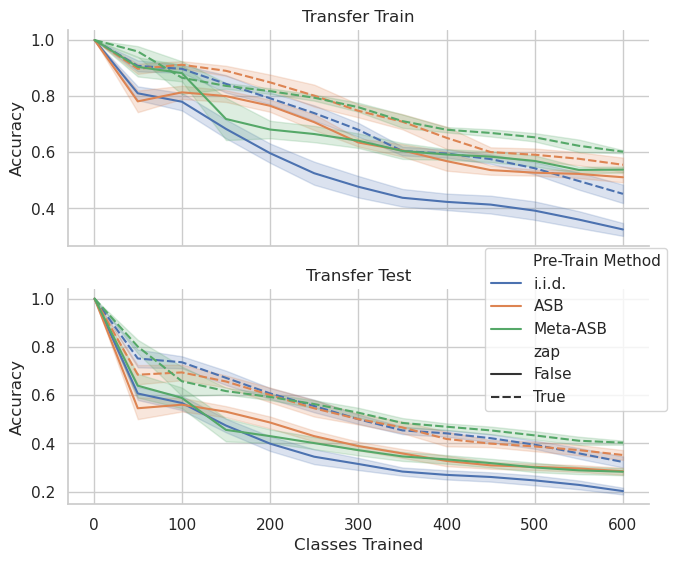

In [42]:
"""
Plotting for main text results: performance of different pre-train treatments on one type of transfer.
"""
legend_pos = None
# Best position for Omniglot Sequential Unfrozen, row mode.
legend_pos = (0.7, 0.27)
# Best position for Omniglot iid Unfrozen, test only.
# legend_pos = (0.68, 0.18)
# Best position for Mini-ImageNet Sequential Unfrozen, row mode.
# legend_pos = (0.7, 0.25)
# Best position for Mini-ImageNet Sequential Unfrozen, col mode.
# legend_pos = (0.81, 0.45)
# Best position for Mini-ImageNet iid Unfrozen, test only.
# legend_pos = (0.68, 0.18)
# Best position for OmnImage-20 Sequential Unfrozen, row mode.
# legend_pos = (0.7, 0.2)
# Best position for OmnImage-20 Sequential Unfrozen, col mode.
# legend_pos = (0.81, 0.35)
# Best position for OmnImage-20 Sequential Unfrozen, test only.
# legend_pos = (0.65, 0.35)

best_overall_no_zaps = filter_zap_rates(best_overall)
add_category_column(best_overall_no_zaps, group_cols[1:])

test_split_only = False
vertical = True
tmp_output_name = output_name
kwargs = {"col": "Split"}
if test_split_only:
    # When excluding the train plot, put the legend outside.
    if not legend_pos:
        legend_pos = "out"
    tmp_output_name += "-test-only"
    best_overall_no_zaps = filter_by_value(best_overall_no_zaps, "split", "test")
elif vertical:
    tmp_output_name += "-vertical"
    kwargs["row"] = kwargs["col"]
    del kwargs["col"]

fg = plot_traj_per_lr(best_overall_no_zaps, hue="Pre-Train Method", style="zap", ci="sd",
                      output_filename=tmp_output_name + ".pdf", legend_pos=legend_pos, **kwargs)

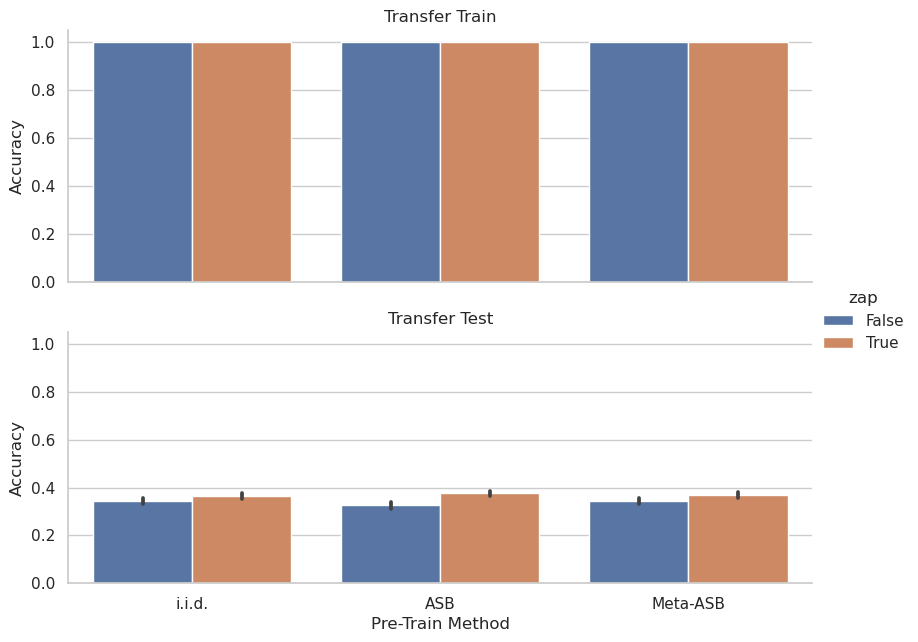

In [31]:
# Categorical plots can't use the index for pivot variables. We need to make them into columns.
temp = best_overall_no_zaps.reset_index(level="zap")
fg = plot_final_perf(temp, x="Pre-Train Method", hue="zap", row="Split", ci="sd")
#                       output_filename=tmp_output_name + ".pdf", legend_pos=legend_pos)

Saving to: sanml-omni-iid-unfrozen-5epochs-transfer-zap-rate.pdf


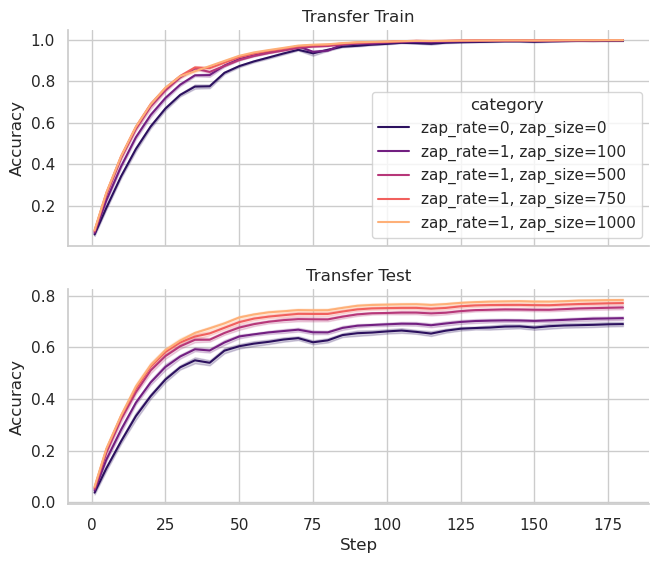

In [235]:
"""
Plotting for supplementary results: performance of different pre-train treatments on one type of transfer.
"""

# Plot zap rate ablation option.
legend_pos = None
# Best position for Omniglot Sequential Unfrozen.
# legend_pos = (0.6, 0.3)
# Best position for Mini-ImageNet Sequential Unfrozen.
# legend_pos = (0.55, 0.2)
best_overall_iid_only = maybe_filter_by_value(best_overall.copy(), "train_method", "iid")
best_overall_iid_only = maybe_filter_by_value(best_overall_iid_only, "zap_biased_steps", 0)
add_category_column(best_overall_iid_only, ["zap_rate", "zap_size"])
fg = plot_traj_per_lr(best_overall_iid_only, hue="category", palette="magma", row="Split",
                      output_filename=output_name + "-zap-rate.pdf", legend_pos=legend_pos)

In [236]:
"""
Table with both pre-train (validation) and transfer performance.
"""
iid_only = False
method_map = {
    "iid": "i.i.d.\\",
    "meta": "Meta-ASB",
    "ASB": "ASB",
    "sequential_episodic": "ASB",
    "seqep": "ASB",
}
tmdex = best_models.index.names.index("train_method")
zapdex = best_models.index.names.index("zap")
zrdex = best_models.index.names.index("zap_rate")
zsdex = best_models.index.names.index("zap_size")
zbsdex = best_models.index.names.index("zap_biased_steps")
for i in range(len(best_models)):
    row = best_models.iloc[i]
    method = row.name[tmdex]
    method_str = method_map[method]
    zap = row.name[zapdex]
    zap_str = 'Y' if zap else 'N'
    zap_rate = row.name[zrdex]
    zap_size = row.name[zsdex]
    acc = row["mean"] * 100
    acc_std = row["std"] * 100
    val = row["val_acc"] * 100
    val_std = row["val_acc_std"] * 100
    if row.name[zbsdex] != 0:
        # Ignore the experimental "biased steps" experiments.
        continue
    if iid_only:
        if method != "iid":
            continue
        col1 = zap_rate
        col2 = zap_size
    else:
        col1 = method_str
        col2 = zap_str
    print(str.format(("{col1:10} & {col2:4} "
                      "& {val:4.1f} {{\\scriptsize $\\pm {val_std:3.1f}$}} "
                      "& {acc:4.1f} {{\\scriptsize $\\pm {acc_std:3.1f}$}} "
                      "\\\\"),
                     col1=col1,
                     col2=col2,
                     acc=acc,
                     acc_std=acc_std,
                     val=val,
                     val_std=val_std,))

i.i.d.\    & N    & 63.5 {\scriptsize $\pm 0.9$} & 69.0 {\scriptsize $\pm 0.8$} \\
i.i.d.\    & Y    & 63.2 {\scriptsize $\pm 1.5$} & 71.3 {\scriptsize $\pm 0.7$} \\
i.i.d.\    & Y    & 66.3 {\scriptsize $\pm 1.2$} & 75.4 {\scriptsize $\pm 0.7$} \\
i.i.d.\    & Y    & 66.7 {\scriptsize $\pm 1.1$} & 77.1 {\scriptsize $\pm 0.7$} \\
i.i.d.\    & Y    & 67.1 {\scriptsize $\pm 1.2$} & 78.4 {\scriptsize $\pm 0.5$} \\
ASB        & N    & 63.0 {\scriptsize $\pm 2.4$} & 69.6 {\scriptsize $\pm 1.0$} \\
ASB        & Y    & 61.9 {\scriptsize $\pm 1.2$} & 78.5 {\scriptsize $\pm 0.8$} \\
Meta-ASB   & N    & 63.5 {\scriptsize $\pm 1.5$} & 68.7 {\scriptsize $\pm 1.0$} \\
Meta-ASB   & Y    & 68.5 {\scriptsize $\pm 0.3$} & 78.1 {\scriptsize $\pm 0.7$} \\


In [237]:
zap_stat_tests = zap_vs_no_zap_test(best_overall, perf_per_model, group_cols)
zap_stat_tests

['train_dataset', 'train_method', 'zap', 'zap_rate', 'zap_size', 'zap_biased_steps', 'zap_biased_fraction', 'zap_biased_params']
('omni', 'ASB', False, 0, 0, 0, 0.0, 0)
('omni', 'ASB', True, 0, 0, 0, 0.0, 0)
Conducting test: deeply-sweetheart-88-9000 vs. effusive-romance-75-9000
('omni', 'ASB', False, 0, 0, 0, 0, 0) | 69.56% (std 1.00%)
('omni', 'ASB', True, 0, 0, 0, 0.0, 0)  | 78.53% (std 0.75%)
p-value = 2.9800516466265548e-09
('omni', 'iid', False, 0, 0, 0, 0.0, 0)
('omni', 'iid', True, 1, 100, 0, 0.0, 0)
Conducting test: attractive-heartthrob-103-570 vs. peachy-lake-6223-570
('omni', 'iid', False, 0, 0, 0, 0, 0) | 69.02% (std 0.80%)
('omni', 'iid', True, 1, 100, 0, 0.0, 0)  | 71.31% (std 0.69%)
p-value = 1.4523800989324718e-10
('omni', 'iid', True, 1, 500, 0, 0.0, 0)
Conducting test: attractive-heartthrob-103-570 vs. spring-hill-6231-570
('omni', 'iid', False, 0, 0, 0, 0, 0) | 69.02% (std 0.80%)
('omni', 'iid', True, 1, 500, 0, 0.0, 0)  | 75.44% (std 0.71%)
p-value = 2.993015625501

control_model             treatment_model  control_mean  \
0      deeply-sweetheart-88-9000    effusive-romance-75-9000      0.695633   
1  attractive-heartthrob-103-570        peachy-lake-6223-570      0.690233   
2  attractive-heartthrob-103-570        spring-hill-6231-570      0.690233   
3  attractive-heartthrob-103-570        glad-valley-6240-570      0.690233   
4  attractive-heartthrob-103-570  beguiling-valentine-93-570      0.690233   
5  attractive-heartthrob-103-570           avid-sunset-2-579      0.690233   
6  attractive-heartthrob-103-570   distinctive-sunset-12-597      0.690233   
7  attractive-heartthrob-103-570         laced-plasma-22-615      0.690233   
8          deeply-crush-70-25000  glorious-voice-28065-25000      0.686811   

   control_std  treatment_mean  treatment_std       p-value  
0     0.010029        0.785350       0.007541  2.980052e-09  
1     0.008020        0.713133       0.006888  1.452380e-10  
2     0.008020        0.754433       0.007119  2.993016e-09  
3     0.008020        0.771500       0.006592  3.004749e-11  
4     0.008020        0.783533       0.005472  3.008520e-11  
5     0.008020        0.781700       0.007252  3.000982e-11  
6     0.008020        0.779456       0.007492  2.993462e-11  
7     0.008020        0.780678       0.006692  3.004749e-11  
8     0.009842        0.780844       0.007336  2.993462e-11

Saving to: sanml-omni-iid-unfrozen-5epochs-transfer-bars.pdf


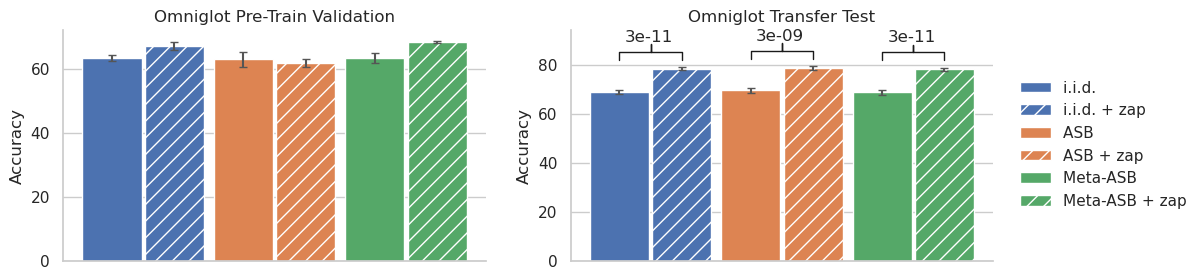

In [238]:
plot_final_perf_custom(best_models, zap_stat_tests, output_name + "-bars.pdf")

## Cross-Domain Transfer

In [ ]:
"""
Plotting for cross-domain transfer results.
"""
train_dataset = "miniimagenet"
best_overall_train_data = filter_by_value(best_overall, "train_dataset", train_dataset)
output_name = "-".join((train_dataset, flavor, "transfer"))

legend_pos = None
best_overall_train_data = filter_zap_rates(best_overall_train_data)
add_category_column(best_overall_train_data, group_cols[1:])
fg = plot_traj_per_lr(best_overall_train_data, hue="Train Method", style="zap",
                      output_filename=output_name + ".pdf", legend_pos=legend_pos)

## Investigate High Variance

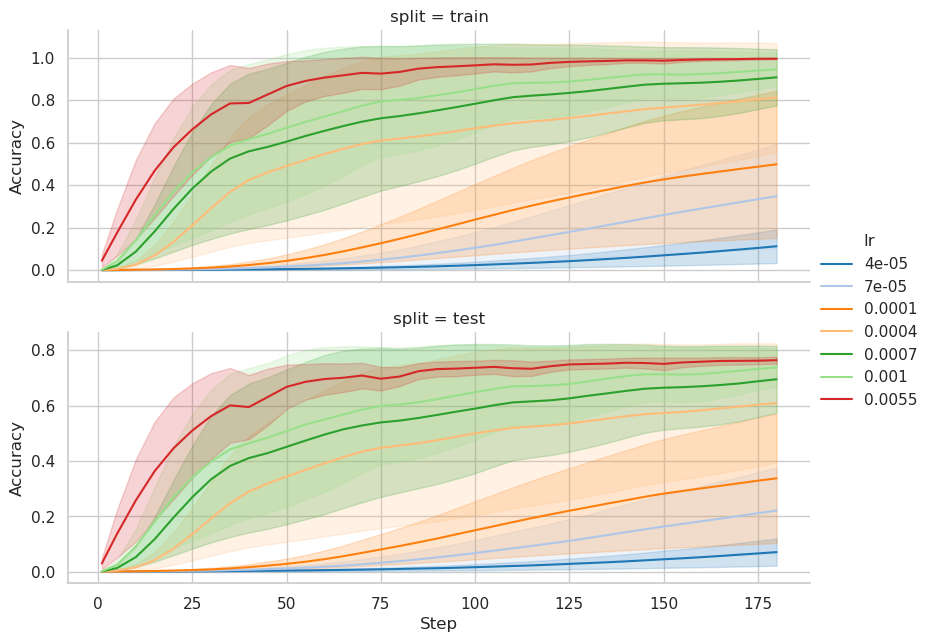

In [152]:
rows = df.index.get_level_values("model") == "effusive-romance-75-9000"
desired_rows = df.loc[rows]
fg = plot_traj_per_lr(desired_rows, palette="tab20")

accuracy
model                    eval_dataset train_examples test_examples eval_method reinit_method reinit_params     opt_params classes epochs batch_size lr     trial epoch step model_name train_dataset train_method zap  zap_rate zap_size train_lr inner_lr outer_lr seed  split          
effusive-romance-75-9000 omni         15             5             iid         kaiming       classifier.linear all        600     5      256        0.0055 0     0     1    sanml      omni          ASB          True 0        0        0.0      0.01     0.001    93242 train  0.073556
                                                                                                                                                                       5    sanml      omni          ASB          True 0        0        0.0      0.01     0.001    93242 train  0.257000
                                                                                                                                                                       10   sanml      omni          ASB          True 0        0        0.0      0.01     0.001    93242 train  0.447889
                                                                                                                                                                       15   sanml      omni          ASB          True 0        0        0.0      0.01     0.001    93242 train  0.631889
                                                                                                                                                                       20   sanml      omni          ASB          True 0        0        0.0      0.01     0.001    93242 train  0.739000
...                                                                                                                                                                                                                                                                                   ...
thrilling-candy-74-9000  omni         15             5             iid         kaiming       classifier.linear all        600     5      256        0.0055 9     4     160  sanml      omni          ASB          True 0        0        0.0      0.01     0.001    29384 test   0.764000
                                                                                                                                                                       165  sanml      omni          ASB          True 0        0        0.0      0.01     0.001    29384 test   0.772333
                                                                                                                                                                       170  sanml      omni          ASB          True 0        0        0.0      0.01     0.001    29384 test   0.773667
                                                                                                                                                                       175  sanml      omni          ASB          True 0        0        0.0      0.01     0.001    29384 test   0.772333
                                                                                                                                                                       180  sanml      omni          ASB          True 0        0        0.0      0.01     0.001    29384 test   0.776667

[2220 rows x 1 columns]

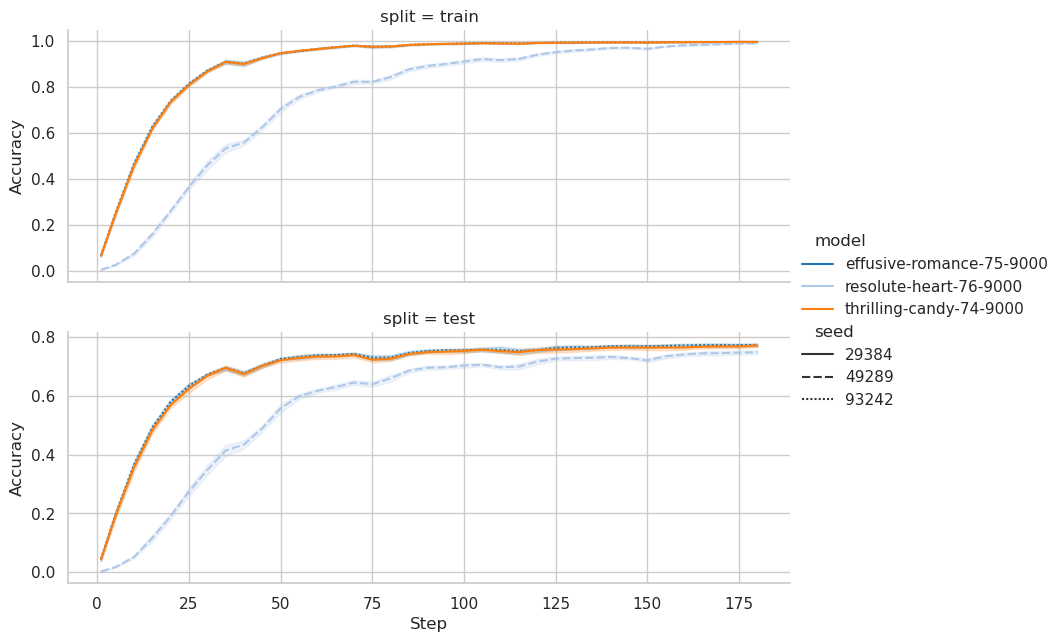

In [154]:
separate_models = combine_train_test_columns(pre_df)
rows = ((separate_models.index.get_level_values("train_lr") == 0.000) & 
        (separate_models.index.get_level_values("inner_lr") == 0.010) & 
        (separate_models.index.get_level_values("outer_lr") == 0.001) & 
        (separate_models.index.get_level_values("zap") == True) & 
        (separate_models.index.get_level_values("train_method") == "ASB") & 
        (separate_models.index.get_level_values("model_name") == "sanml") & 
        (separate_models.index.get_level_values("lr") == 0.0055))
desired_rows = separate_models.loc[rows]
fg = plot_traj_per_lr(desired_rows, style="seed", palette="tab20")
desired_rows

# ANML vs. SANML

In [67]:
%%time
# Just analyze a single flavor for the target dataset.
flavor = "olft"
eval_dataset = "omni"
target_df = all_frames[flavor]
target_df = filter_by_value(target_df, "eval_dataset", eval_dataset)

### OR ###

# Combine all models that were transferred to the target dataset.
# flavor = "cross-domain-omniglot"
# df1 = all_frames["iid-unfrozen-5epochs-omniglot"]
# df2 = all_frames["iid-unfrozen-5epochs"].copy()
# df2 = filter_by_value(df2, "eval_dataset", "omni")
# target_df = pd.concat([df1, df2])
# target_df = filter_by_value(target_df, "batch_size", 256)

CPU times: user 18.5 s, sys: 2.99 s, total: 21.5 s
Wall time: 30 s


In [68]:
%%time
pre_df = drop_top5_columns(target_df)
pre_df = summarize_per_class_performance(pre_df, inplace=True)
print(f"Train examples: {list(pre_df.index.get_level_values('train_examples').unique())}")
print(f"Test examples: {list(pre_df.index.get_level_values('test_examples').unique())}")

Train examples: [15]
Test examples: [5]
CPU times: user 57.4 s, sys: 9.64 s, total: 1min 7s
Wall time: 1min 6s


In [69]:
%%time
num_train_examples = None
output_name, group_cols, perf_per_model, best_models, best_overall = \
    prep_best_models_for_plotting(pre_df, num_train_examples)
best_models

CPU times: user 6.97 s, sys: 66.2 ms, total: 7.03 s
Wall time: 7.45 s


mean  \
train_dataset train_method zap   zap_rate zap_size zap_biased_steps zap_biased_fraction zap_biased_params model_name model                         category                                           Pre-Train Setting train_method_sorted             
omni          iid          False 0        0        0                0.0                 0                 sanml      attractive-heartthrob-103-570 method=iid, zap=False, zap_rate=0, zap_size=0, ... Convnet i.i.d.    11                   0.419778   
                           True  1        100      0                0.0                 0                 sanml      peachy-lake-6223-570          method=iid, zap=True, zap_rate=1, zap_size=100,... Convnet i.i.d.    11                   0.462333   
                                          500      0                0.0                 0                 sanml      spring-hill-6231-570          method=iid, zap=True, zap_rate=1, zap_size=500,... Convnet i.i.d.    11                   0.523200   
                                          750      0                0.0                 0                 sanml      glad-valley-6240-570          method=iid, zap=True, zap_rate=1, zap_size=750,... Convnet i.i.d.    11                   0.547400   
                                          1000     0                0.0                 0                 sanml      beguiling-valentine-93-570    method=iid, zap=True, zap_rate=1, zap_size=1000... Convnet i.i.d.    11                   0.563811   
                                                   1                0.5                 classifier.linear sanml      avid-sunset-2-579             method=iid, zap=True, zap_rate=1, zap_size=1000... Convnet i.i.d.    11                   0.562156   
                                                   3                0.5                 classifier.linear sanml      distinctive-sunset-12-597     method=iid, zap=True, zap_rate=1, zap_size=1000... Convnet i.i.d.    11                   0.563333   
                                                   5                0.5                 classifier.linear sanml      laced-plasma-22-615           method=iid, zap=True, zap_rate=1, zap_size=1000... Convnet i.i.d.    11                   0.560211   
              ASB          False 0        0        0                0.0                 0                 sanml      deeply-sweetheart-88-9000     method=ASB, zap=False, zap_rate=0, zap_size=0, ... Convnet ASB       12                   0.426467   
                           True  0        0        0                0.0                 0                 sanml      effusive-romance-75-9000      method=ASB, zap=True, zap_rate=0, zap_size=0, z... Convnet ASB       12                   0.570333   
              meta         False 0        0        0                0.0                 0                 sanml      blazing-tulip-66-25000        method=meta, zap=False, zap_rate=0, zap_size=0,... Convnet Meta-ASB  13                   0.422233   
                           True  0        0        0                0.0                 0                 sanml      glorious-voice-28065-25000    method=meta, zap=True, zap_rate=0, zap_size=0, ... Convnet Meta-ASB  13                   0.675689   
                           False 0        0        0                0.0                 0                 anml       stellar-fire-28591-25000      method=meta, zap=False, zap_rate=0, zap_size=0,... ANML              23                   0.415211   
                           True  0        0        0                0.0                 0                 anml       elated-durian-28174-25000     method=meta, zap=True, zap_rate=0, zap_size=0, ... ANML              23                   0.670178   

                                                                                                                                                                                                                                                  std  \
train_d

Saving to: omni-olft-transfer-anml-vs-sanml-meta-test-only.pdf


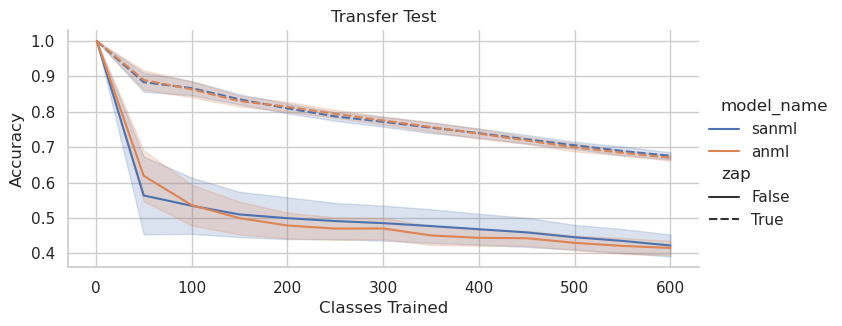

In [79]:
"""
Compare different models under meta-training only.
"""
legend_pos = None
# Best position for Omniglot Sequential Unfrozen, row mode.
# legend_pos = (0.70, 0.25)
# Best position for Omniglot Sequential Unfrozen, col mode.
# legend_pos = (0.83, 0.45)

best_overall_no_zaps = filter_zap_rates(best_overall)
add_category_column(best_overall_no_zaps, group_cols[1:])

train_method = "meta"
best_overall_no_zaps = filter_by_value(best_overall_no_zaps, "train_method", train_method)

test_split_only = True
vertical = True
tmp_output_name = output_name + f"-anml-vs-sanml-{train_method}"
kwargs = {"col": "Split"}
if test_split_only:
    # When excluding the train plot, put the legend outside.
    if not legend_pos:
        legend_pos = "out"
    tmp_output_name += "-test-only"
    best_overall_no_zaps = filter_by_value(best_overall_no_zaps, "split", "test")
elif vertical:
    tmp_output_name += "-vertical"
    kwargs["row"] = kwargs["col"]
    del kwargs["col"]

fg = plot_traj_per_lr(best_overall_no_zaps, hue="model_name", style="zap",
                      output_filename=tmp_output_name + ".pdf", legend_pos=legend_pos, **kwargs)

Saving to: omni-olft-transfer-all-models-test-only.pdf


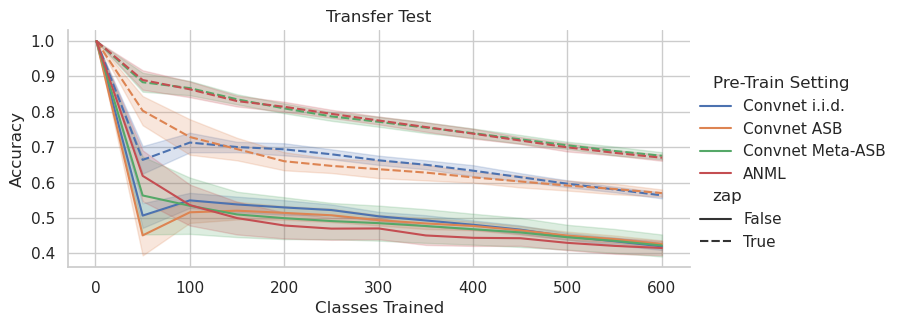

In [81]:
"""
Include all models as different pre-train methods.
"""
legend_pos = None
# Best position for Omniglot Sequential OLFT, row mode.
# legend_pos = (0.1, 0.50)
# Best position for Omniglot Sequential Unfrozen, col mode.
# legend_pos = (0.81, 0.43)

best_overall_no_zaps = filter_zap_rates(best_overall)
add_category_column(best_overall_no_zaps, ["train_method", "model_name"])

test_split_only = True
vertical = True
tmp_output_name = output_name + f"-all-models"
kwargs = {"col": "Split"}
if test_split_only:
    # When excluding the train plot, put the legend outside.
    if not legend_pos:
        legend_pos = "out"
    tmp_output_name += "-test-only"
    best_overall_no_zaps = filter_by_value(best_overall_no_zaps, "split", "test")
elif vertical:
    tmp_output_name += "-vertical"
    kwargs["row"] = kwargs["col"]
    del kwargs["col"]

fg = plot_traj_per_lr(best_overall_no_zaps, hue="Pre-Train Setting", style="zap",
                      output_filename=tmp_output_name + ".pdf", legend_pos=legend_pos, **kwargs)

In [48]:
zap_stat_tests = zap_vs_no_zap_test(best_overall, perf_per_model, group_cols)
zap_stat_tests

['train_dataset', 'train_method', 'zap', 'zap_rate', 'zap_size', 'zap_biased_steps', 'zap_biased_fraction', 'zap_biased_params', 'model_name']
('omni', 'ASB', False, 0, 0, 0, 0.0, 0, 'sanml')
('omni', 'ASB', True, 0, 0, 0, 0.0, 0, 'sanml')
Conducting test: deeply-sweetheart-88-9000 vs. enamored-crush-77-9000
('omni', 'ASB', False, 0, 0, 0, 0, 0, 'sanml') | 28.50% (std 1.45%)
('omni', 'ASB', True, 0, 0, 0, 0.0, 0, 'sanml')  | 35.24% (std 2.03%)
p-value = 6.67528550360204e-11
('omni', 'iid', False, 0, 0, 0, 0.0, 0, 'sanml')
('omni', 'iid', True, 1, 100, 0, 0.0, 0, 'sanml')
Conducting test: attractive-heartthrob-103-570 vs. peachy-lake-6223-570
('omni', 'iid', False, 0, 0, 0, 0, 0, 'sanml') | 20.29% (std 1.39%)
('omni', 'iid', True, 1, 100, 0, 0.0, 0, 'sanml')  | 23.52% (std 2.52%)
p-value = 1.0640758887602666e-06
('omni', 'iid', True, 1, 500, 0, 0.0, 0, 'sanml')
Conducting test: attractive-heartthrob-103-570 vs. spring-hill-6231-570
('omni', 'iid', False, 0, 0, 0, 0, 0, 'sanml') | 20.29%

control_model             treatment_model  control_mean  \
0      deeply-sweetheart-88-9000      enamored-crush-77-9000      0.284989   
1  attractive-heartthrob-103-570        peachy-lake-6223-570      0.202867   
2  attractive-heartthrob-103-570        spring-hill-6231-570      0.202867   
3  attractive-heartthrob-103-570        glad-valley-6240-570      0.202867   
4  attractive-heartthrob-103-570  beguiling-valentine-93-570      0.202867   
5  attractive-heartthrob-103-570           avid-sunset-2-579      0.202867   
6  attractive-heartthrob-103-570   distinctive-sunset-12-597      0.202867   
7  attractive-heartthrob-103-570         laced-plasma-22-615      0.202867   
8      elated-brook-156076-25000     prime-bird-156067-25000      0.246744   
9          deeply-crush-70-25000    cherubic-flower-58-25000      0.283056   

   control_std  treatment_mean  treatment_std       p-value  
0     0.014453        0.352367       0.020336  6.675286e-11  
1     0.013923        0.235200       0.025203  1.064076e-06  
2     0.013923        0.285167       0.025958  2.993016e-09  
3     0.013923        0.307533       0.030002  3.006634e-11  
4     0.013923        0.323400       0.022826  2.999101e-11  
5     0.013923        0.276900       0.026152  3.002865e-11  
6     0.013923        0.285711       0.034454  3.155412e-11  
7     0.013923        0.299922       0.027113  3.004749e-11  
8     0.010350        0.253144       0.009498  3.505033e-02  
9     0.014463        0.403344       0.008276  3.004749e-11

Saving to: omni-unfrozen-transfer-all-models-bars.pdf


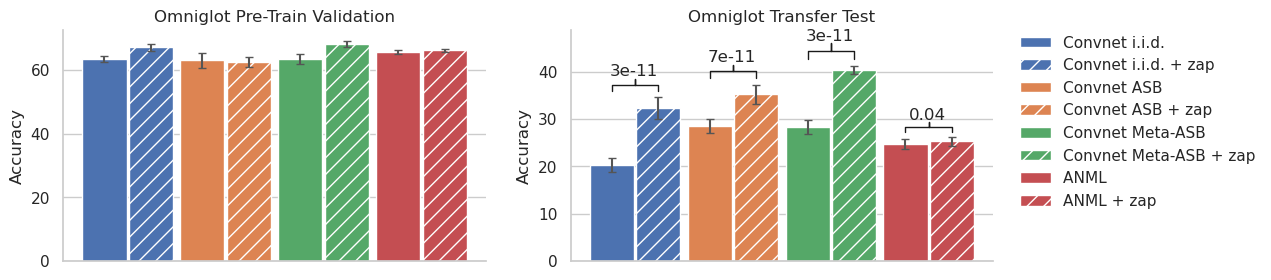

In [49]:
plot_final_perf_custom(best_models, zap_stat_tests, output_name + "-all-models-bars.pdf")

# Determine the "Best" Versions of Each Pre-Train Type

For each of the different pre-train settings we're interested in, we've trained that setting with a number of different hyperparameters. Within each setting, we want to select the best single set of hyperparams. We'll do this by using the No-SGD performance as a proxy for overall "goodness".

In [22]:
# Using No-SGD performance as a proxy for overall performance.
perf_proxy = all_frames["no-sgd"]

# Make sure we are using the full downstream dataset to estimate performance.
# TODO: This only works for one dataset at a time. Currently not being used in the rest of analysis.
rows = ((perf_proxy.index.get_level_values("eval_dataset") == "miniimagenet") &
        (perf_proxy.index.get_level_values("train_examples") == 30))
desired_rows = perf_proxy.loc[rows]

# Group the potential data for each data point separately. So each group contains all trials and all learning rates for
# a single test method (so all index columns except for those).
perf_proxy_pretrain_groups = desired_rows.groupby(
    ["train_dataset", "train_method", "zap", "zap_rate", "zap_size"], dropna=False)

def select_best_model(train_group):
    """
    Returns the best model among this group, according to mean test accuracy.
    """
    model_perf = train_group.groupby("model").mean()
    # Tells us which LR is the best.
    return model_perf.iloc[model_perf.loc[:, "test_acc"].argmax()].name

# For each point on the x-axis, select the learning rate with the best average performance over trials.
# Need to use .apply() here because our function needs all columns at once.
best_model_per_setting = perf_proxy_pretrain_groups.apply(select_best_model)
best_model_per_setting

train_dataset  train_method         zap    zap_rate  zap_size
miniimagenet   iid                  False  0         0                   bright-peony-266-3750
                                    True   1         10              generous-aardvark-19-3750
                                                     32                   proud-vortex-28-3750
                                                     48              crimson-microwave-37-3750
                                                     64                   fiery-breeze-49-3750
               meta                 False  0         0           blooming-resonance-3585-25000
                                    True   0         0                fragrant-tree-3494-25000
               sequential_episodic  False  0         0             blooming-universe-3825-9000
                                    True   0         0                    smart-haze-3780-9000
dtype: object

# Sequential Fine-Tuning Evaluation

Below is a more verbose sequence of cells for processing the sequential transfer results (`"unfrozen"`)

## Sequential Unfrozen

Summarize the unfrozen sequential transfer learning, and view the dataframe to check the structure.

In [19]:
%%time

olft = all_frames["unfrozen"]
olft = filter_by_value(olft, "train_dataset", "omni")
olft_over_all_classes = summarize_per_class_performance(olft)
olft_over_all_classes

CPU times: user 38.8 s, sys: 8.79 s, total: 47.6 s
Wall time: 52.1 s


train_acc  \
model                eval_dataset train_examples test_examples eval_method reinit_method reinit_params     opt_params classes lr      trial epoch classes_trained model_name train_dataset train_method lobotomize lobo_rate lobo_size train_lr inner_lr outer_lr seed               
ablaze-ring-62-25000 omni         15             5             sequential  kaiming       classifier.linear all        600     0.00004 0     0     1               sanml      omni          meta         True       0         0         0.0000   0.001    0.01     29384   0.000000   
                                                                                                                                            49    50              sanml      omni          meta         True       0         0         0.0000   0.001    0.01     29384   0.040000   
                                                                                                                                            99    100             sanml      omni          meta         True       0         0         0.0000   0.001    0.01     29384   0.104000   
                                                                                                                                            149   150             sanml      omni          meta         True       0         0         0.0000   0.001    0.01     29384   0.170222   
                                                                                                                                            199   200             sanml      omni          meta         True       0         0         0.0000   0.001    0.01     29384   0.223333   
...                                                                                                                                                                                                                                                                            ...   
zesty-surf-6228-570  omni         15             5             sequential  kaiming       classifier.linear all        600     0.00550 9     399   400             sanml      omni          iid          False      1         100       0.0003   0.000    0.00     93242   0.004500   
                                                                                                                                            449   450             sanml      omni          iid          False      1         100       0.0003   0.000    0.00     93242   0.003259   
                                                                                                                                            499   500             sanml      omni          iid          False      1         100       0.0003   0.000    0.00     93242   0.001867   
                                                                                                                                            549   550             sanml      omni          iid          False      1         100       0.0003   0.000    0.00     93242   0.001455   
                                                                                                                                            599   600             sanml      omni          iid          False      1         100       0.0003   0.000    0.00     93242   0.003778   

                                                                                                                                                                                                                                                                         test_acc  
model                eval_dataset train_examples test_examples eval_method reinit_method reinit_params     opt_params classes lr      trial epoch classes_trained model_name train_dataset train_method lobotomize lobo_rate lobo_size train_lr inner_lr outer_lr seed             
ablaze-ring-62-25000 omni         15             5             sequential  kaiming       classifie

In [20]:
get_model_descriptions(olft_over_all_classes)

model_name train_dataset train_method  \
model                                                                 
ablaze-ring-62-25000               sanml          omni         meta   
affectionate-flower-96-570         sanml          omni          iid   
angelic-balloon-100-570            sanml          omni          iid   
attractive-cupid-107-570           sanml          omni          iid   
attractive-heartthrob-103-570      sanml          omni          iid   
...                                  ...           ...          ...   
wild-puddle-6230-570               sanml          omni          iid   
wise-dust-6239-570                 sanml          omni          iid   
wobbly-thunder-6236-570            sanml          omni          iid   
wooing-smooch-104-570              sanml          omni          iid   
zesty-surf-6228-570                sanml          omni          iid   

                               lobotomize  lobo_rate  lobo_size  train_lr  \
model                                                                       
ablaze-ring-62-25000                 True          0          0    0.0000   
affectionate-flower-96-570          False          1       1000    0.0010   
angelic-balloon-100-570             False          1       1000    0.0003   
attractive-cupid-107-570            False          0          0    0.0003   
attractive-heartthrob-103-570       False          0          0    0.0030   
...                                   ...        ...        ...       ...   
wild-puddle-6230-570                False          1        500    0.0030   
wise-dust-6239-570                  False          1        750    0.0030   
wobbly-thunder-6236-570             False          1        500    0.0003   
wooing-smooch-104-570               False          0          0    0.0010   
zesty-surf-6228-570                 False          1        100    0.0003   

                               inner_lr  outer_lr   seed  
model                                                     
ablaze-ring-62-25000              0.001      0.01  29384  
affectionate-flower-96-570        0.000      0.00  93242  
angelic-balloon-100-570           0.000      0.00  49289  
attractive-cupid-107-570          0.000      0.00  29384  
attractive-heartthrob-103-570     0.000      0.00  49289  
...                                 ...       ...    ...  
wild-puddle-6230-570              0.000      0.00  29384  
wise-dust-6239-570                0.000      0.00  29384  
wobbly-thunder-6236-570           0.000      0.00  29384  
wooing-smooch-104-570             0.000      0.00  29384  
zesty-surf-6228-570               0.000      0.00  93242  

[80 rows x 10 columns]

Melt the two train/test accuracy columns into one, to make it easier to plot both simultaneously with Seaborn.

In [21]:
olft_overall_accuracy = combine_train_test_columns(olft_over_all_classes)

Rename models so we can more easily aggregate the random seeds together and get error bars over all training runs. Check the model descriptions to verify that models have been successfully divided into unique categories.

In [22]:
olft_overall_accuracy = rename_like_models(olft_overall_accuracy)

In [23]:
olft_overall_accuracy
get_model_descriptions(olft_overall_accuracy)

model_name train_dataset  \
model                                                       
ablaze-ring-62-25000                  sanml          omni   
affectionate-flower-96-570            sanml          omni   
angelic-balloon-100-570               sanml          omni   
attractive-cupid-107-570              sanml          omni   
attractive-heartthrob-103-570         sanml          omni   
beguiling-valentine-93-570            sanml          omni   
blazing-darling-60-25000              sanml          omni   
blazing-tulip-66-25000                sanml          omni   
cherubic-flower-58-25000              sanml          omni   
clear-butterfly-6227-570              sanml          omni   
confused-disco-6224-570               sanml          omni   
constant-violet-85-9000               sanml          omni   
dedicated-darling-82-9000             sanml          omni   
deeply-crush-70-25000                 sanml          omni   
deeply-sweetheart-88-9000             sanml          omni   
dreamy-heart-71-25000                 sanml          omni   
eager-deluge-6242-570                 sanml          omni   
eager-quiver-106-570                  sanml          omni   
effusive-romance-75-9000              sanml          omni   
enamored-crush-77-9000                sanml          omni   
enthusiastic-candy-heart-90-9000      sanml          omni   
ethereal-water-6238-570               sanml          omni   
glad-valley-6240-570                  sanml          omni   
hopeful-fire-6247-570                 sanml          omni   
kind-sponge-6235-570                  sanml          omni   
peachy-lake-6223-570                  sanml          omni   
spring-hill-6231-570                  sanml          omni   

                                         train_method  lobotomize  lobo_rate  \
model                                                                          
ablaze-ring-62-25000                             meta        True          0   
affectionate-flower-96-570                        iid       False          1   
angelic-balloon-100-570                           iid       False          1   
attractive-cupid-107-570                          iid       False          0   
attractive-heartthrob-103-570                     iid       False          0   
beguiling-valentine-93-570                        iid       False          1   
blazing-darling-60-25000                         meta        True          0   
blazing-tulip-66-25000                           meta       False          0   
cherubic-flower-58-25000                         meta        True          0   
clear-butterfly-6227-570                          iid       False          1   
confused-disco-6224-570                           iid       False          1   
constant-violet-85-9000           sequential_episodic       False          0   
dedicated-darling-82-9000         sequential_episodic        True          0   
deeply-crush-70-25000                            meta       False          0   
deeply-sweetheart-88-9000         sequential_episodic       False          0   
dreamy-heart-71-25000                            meta       False          0   
eager-deluge-6242-570                             iid       False          1   
eager-quiver-106-570                              iid       False          0   
effusive-romance-75-9000          sequential_episodic        True          0   
enamored-crush-77-9000            sequential_episodic        True          0   
enthusiastic-candy-heart-90-9000  sequential_episodic       False          0   
ethereal-water-6238-570                           iid       False          1   
glad-valley-6240-570                              iid       False          1   
hopeful-fire-6247-570                             iid       False          1   
kind-sponge-6235-570                              iid       False          1   
peachy-lake-6223-570                              iid       False          1   
spring-hill-6231-570   

Now, plot a graph with the best learning rate per data point.

In [24]:
olft_overall_accuracy.index.get_level_values("train_examples").unique()

Int64Index([15], dtype='int64', name='train_examples')

In [25]:
# Filter the data to just N examples per class.
# num_train_examples = 10
# rows = olft_overall_accuracy.index.get_level_values("train_examples") == num_train_examples
# olft_one_train_size = olft_overall_accuracy.loc[rows]

# Or, don't filter.
num_train_examples = None
olft_one_train_size = olft_overall_accuracy

# Now select one LR per pretrain group.
olft_best_lrs = select_best_lr_per_group(olft_one_train_size)

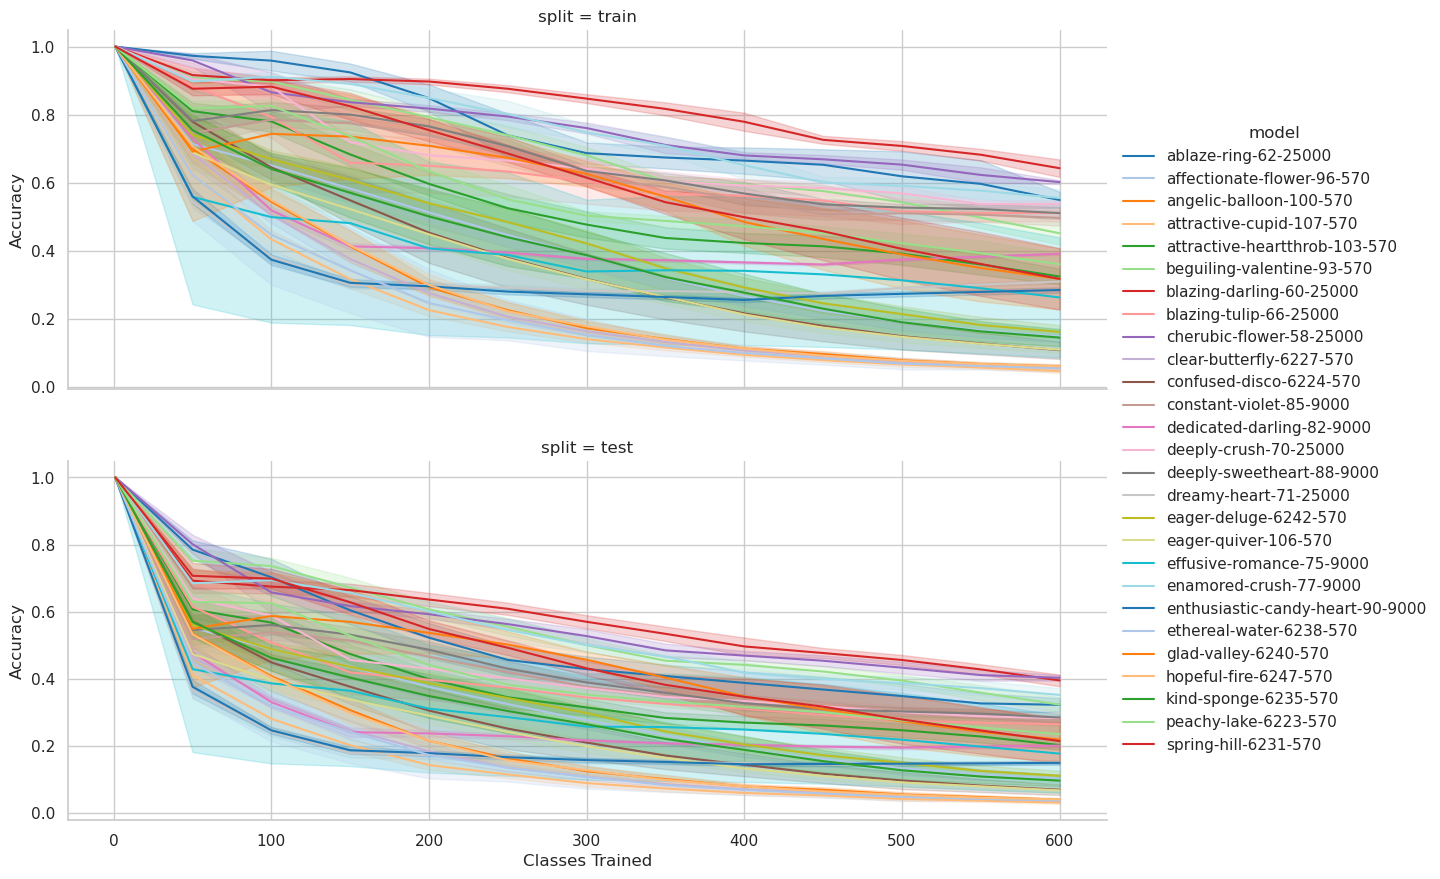

In [26]:
# Plot results
fg = plot_traj_per_lr(olft_best_lrs, palette="tab20")

Or we could also plot a graph with just one model, all learning rates.

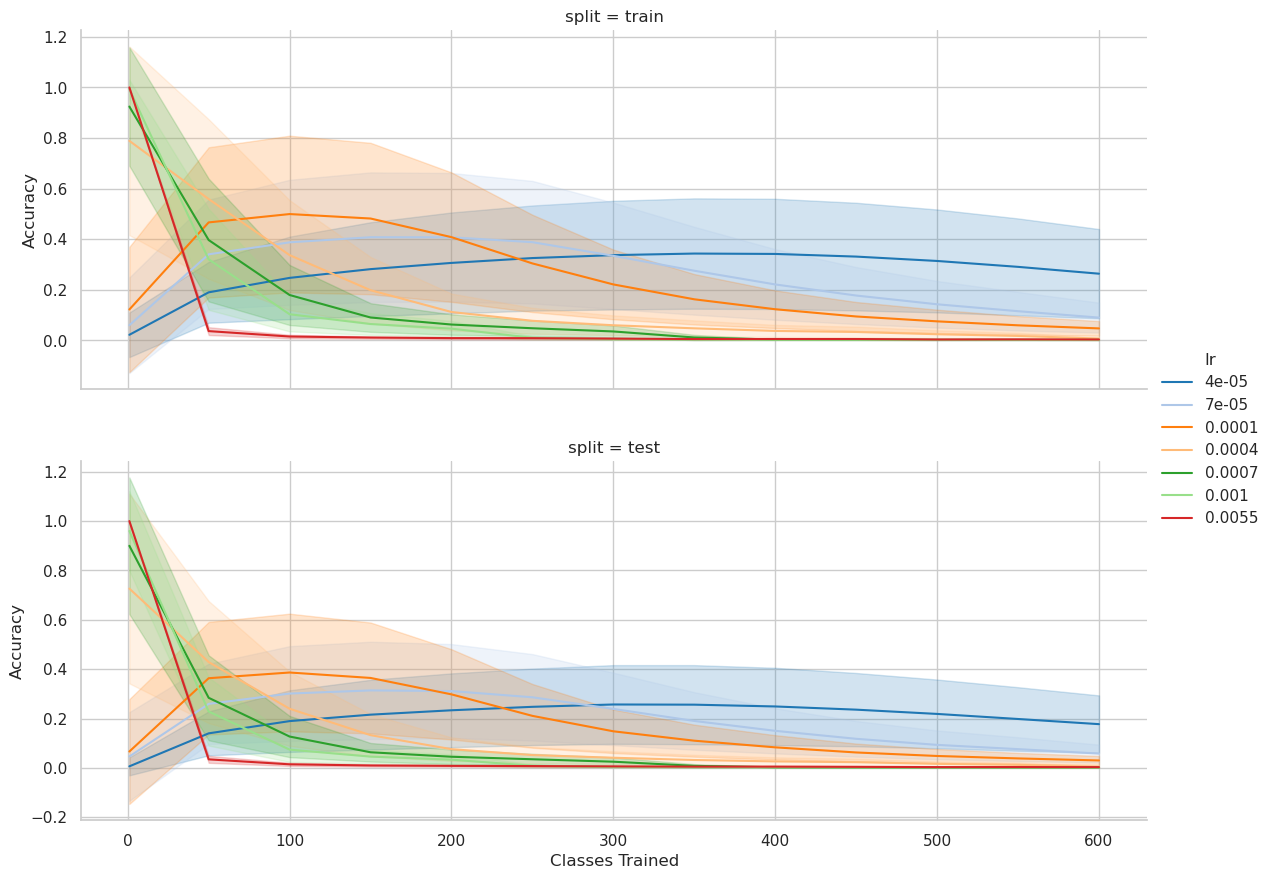

In [27]:
rows = olft_one_train_size.index.get_level_values("model") == "effusive-romance-75-9000"
desired_rows = olft_one_train_size.loc[rows]
fg = plot_traj_per_lr(desired_rows, palette="tab20")

accuracy
model                    eval_dataset train_examples test_examples eval_method reinit_method reinit_params     opt_params classes lr     trial epoch classes_trained model_name train_dataset train_method        lobotomize lobo_rate lobo_size train_lr inner_lr outer_lr seed  split          
effusive-romance-75-9000 omni         15             5             sequential  kaiming       classifier.linear all        600     0.0001 0     0     1               sanml      omni          sequential_episodic True       0         0         0.0      0.01     0.001    93242 train  0.533333
                                                                                                                                               49    50              sanml      omni          sequential_episodic True       0         0         0.0      0.01     0.001    93242 train  0.692000
                                                                                                                                               99    100             sanml      omni          sequential_episodic True       0         0         0.0      0.01     0.001    93242 train  0.733333
                                                                                                                                               149   150             sanml      omni          sequential_episodic True       0         0         0.0      0.01     0.001    93242 train  0.717333
                                                                                                                                               199   200             sanml      omni          sequential_episodic True       0         0         0.0      0.01     0.001    93242 train  0.619000
...                                                                                                                                                                                                                                                                                           ...
thrilling-candy-74-9000  omni         15             5             sequential  kaiming       classifier.linear all        600     0.0001 9     399   400             sanml      omni          sequential_episodic True       0         0         0.0      0.01     0.001    29384 test   0.091000
                                                                                                                                               449   450             sanml      omni          sequential_episodic True       0         0         0.0      0.01     0.001    29384 test   0.080000
                                                                                                                                               499   500             sanml      omni          sequential_episodic True       0         0         0.0      0.01     0.001    29384 test   0.069200
                                                                                                                                               549   550             sanml      omni          sequential_episodic True       0         0         0.0      0.01     0.001    29384 test   0.050909
                                                                                                                                               599   600             sanml      omni          sequential_episodic True       0         0         0.0      0.01     0.001    29384 test   0.030333

[780 rows x 1 columns]

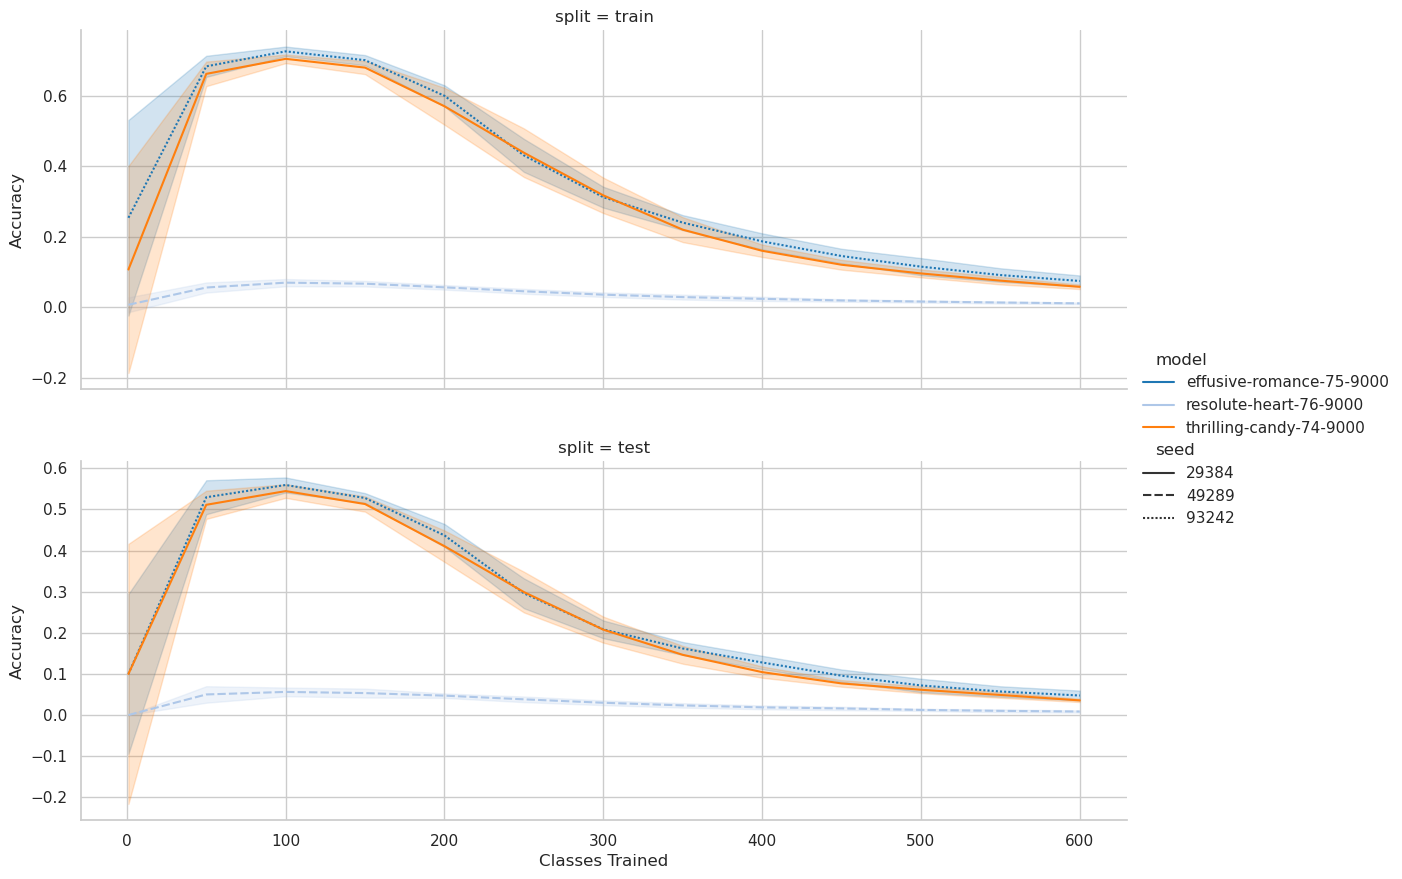

In [28]:
separate_models = combine_train_test_columns(olft_over_all_classes)
rows = ((separate_models.index.get_level_values("train_lr") == 0.000) & 
        (separate_models.index.get_level_values("inner_lr") == 0.010) & 
        (separate_models.index.get_level_values("outer_lr") == 0.001) & 
        (separate_models.index.get_level_values("zap") == True) & 
        (separate_models.index.get_level_values("train_method") == "ASB") & 
        (separate_models.index.get_level_values("model_name") == "sanml") & 
        (separate_models.index.get_level_values("lr") == 0.0001))
desired_rows = separate_models.loc[rows]
fg = plot_traj_per_lr(desired_rows, style="seed", palette="tab20")
desired_rows

### Best Models Overall

Rate each model based on final test performance with its best LR. Also show training details for each model.

In [29]:
# Print final accuracy per model, when fine-tuned on this number of examples.
olft_perf_per_model = get_final_perf_per_model(olft_best_lrs, num_train_examples, print_result=True)

Final accuracy on 600 classes:
          ablaze-ring-62-25000 | 32.3% (std: 2.0%)
    affectionate-flower-96-570 | 10.3% (std: 1.2%)
       angelic-balloon-100-570 |  4.1% (std: 0.4%)
      attractive-cupid-107-570 |  3.1% (std: 0.4%)
 attractive-heartthrob-103-570 | 20.3% (std: 1.4%)
    beguiling-valentine-93-570 | 32.3% (std: 2.3%)
      blazing-darling-60-25000 | 39.5% (std: 1.7%)
        blazing-tulip-66-25000 | 26.5% (std: 2.5%)
      cherubic-flower-58-25000 | 40.3% (std: 0.8%)
      clear-butterfly-6227-570 |  3.8% (std: 0.4%)
       confused-disco-6224-570 |  7.0% (std: 1.6%)
       constant-violet-85-9000 | 27.5% (std: 1.5%)
     dedicated-darling-82-9000 | 20.1% (std: 0.5%)
         deeply-crush-70-25000 | 28.3% (std: 1.4%)
     deeply-sweetheart-88-9000 | 28.5% (std: 1.4%)
         dreamy-heart-71-25000 | 15.1% (std: 0.6%)
         eager-deluge-6242-570 | 11.1% (std: 1.5%)
          eager-quiver-106-570 |  6.8% (std: 0.8%)
      effusive-romance-75-9000 | 17.8% (std: 11.6%)

In [30]:
get_model_descriptions(olft_best_lrs)

model_name train_dataset  \
model                                                       
ablaze-ring-62-25000                  sanml          omni   
affectionate-flower-96-570            sanml          omni   
angelic-balloon-100-570               sanml          omni   
attractive-cupid-107-570              sanml          omni   
attractive-heartthrob-103-570         sanml          omni   
beguiling-valentine-93-570            sanml          omni   
blazing-darling-60-25000              sanml          omni   
blazing-tulip-66-25000                sanml          omni   
cherubic-flower-58-25000              sanml          omni   
clear-butterfly-6227-570              sanml          omni   
confused-disco-6224-570               sanml          omni   
constant-violet-85-9000               sanml          omni   
dedicated-darling-82-9000             sanml          omni   
deeply-crush-70-25000                 sanml          omni   
deeply-sweetheart-88-9000             sanml          omni   
dreamy-heart-71-25000                 sanml          omni   
eager-deluge-6242-570                 sanml          omni   
eager-quiver-106-570                  sanml          omni   
effusive-romance-75-9000              sanml          omni   
enamored-crush-77-9000                sanml          omni   
enthusiastic-candy-heart-90-9000      sanml          omni   
ethereal-water-6238-570               sanml          omni   
glad-valley-6240-570                  sanml          omni   
hopeful-fire-6247-570                 sanml          omni   
kind-sponge-6235-570                  sanml          omni   
peachy-lake-6223-570                  sanml          omni   
spring-hill-6231-570                  sanml          omni   

                                         train_method  lobotomize  lobo_rate  \
model                                                                          
ablaze-ring-62-25000                             meta        True          0   
affectionate-flower-96-570                        iid       False          1   
angelic-balloon-100-570                           iid       False          1   
attractive-cupid-107-570                          iid       False          0   
attractive-heartthrob-103-570                     iid       False          0   
beguiling-valentine-93-570                        iid       False          1   
blazing-darling-60-25000                         meta        True          0   
blazing-tulip-66-25000                           meta       False          0   
cherubic-flower-58-25000                         meta        True          0   
clear-butterfly-6227-570                          iid       False          1   
confused-disco-6224-570                           iid       False          1   
constant-violet-85-9000           sequential_episodic       False          0   
dedicated-darling-82-9000         sequential_episodic        True          0   
deeply-crush-70-25000                            meta       False          0   
deeply-sweetheart-88-9000         sequential_episodic       False          0   
dreamy-heart-71-25000                            meta       False          0   
eager-deluge-6242-570                             iid       False          1   
eager-quiver-106-570                              iid       False          0   
effusive-romance-75-9000          sequential_episodic        True          0   
enamored-crush-77-9000            sequential_episodic        True          0   
enthusiastic-candy-heart-90-9000  sequential_episodic       False          0   
ethereal-water-6238-570                           iid       False          1   
glad-valley-6240-570                              iid       False          1   
hopeful-fire-6247-570                             iid       False          1   
kind-sponge-6235-570                              iid       False          1   
peachy-lake-6223-570                              iid       False          1   
spring-hill-6231-570   

In [31]:
# Get the top N models according to final test performance.
num_top_models = 5
sorted_models = sorted(olft_perf_per_model, key=lambda k: olft_perf_per_model[k]["mean"].item(), reverse=True)
top_models = sorted_models[:num_top_models]
print(f"Top models: {top_models}")
top_model_df = filter_by_model(olft_best_lrs, top_models)

Top models: ['cherubic-flower-58-25000', 'blazing-darling-60-25000', 'enamored-crush-77-9000', 'beguiling-valentine-93-570', 'ablaze-ring-62-25000']


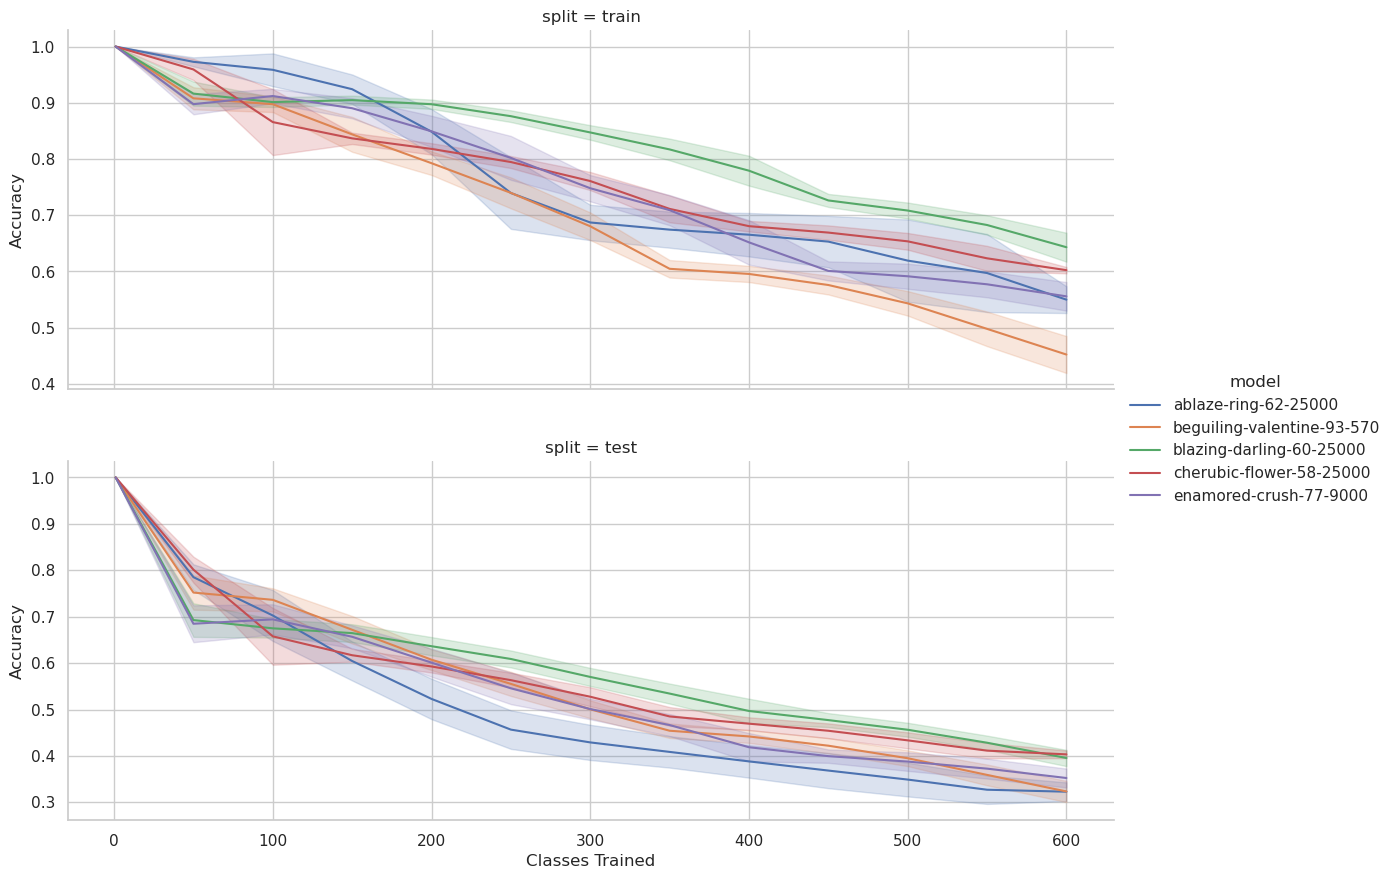

In [32]:
# Re-do the plot with just the top models.
_ = plot_traj_per_lr(top_model_df)

### Best Models Per Category

In [33]:
group_cols = ["model_name", "train_method", "zap", "zap_rate", "zap_size"]
best_olft_models = get_top_model_per_group(olft_best_lrs, olft_perf_per_model, group_cols)
best_olft_models

mean  \
model_name train_method        lobotomize lobo_rate lobo_size model                                     
sanml      iid                 False      0         0         attractive-heartthrob-103-570  0.202867   
                                          1         100       peachy-lake-6223-570           0.235200   
                                                    500       spring-hill-6231-570           0.215000   
                                                    750       glad-valley-6240-570           0.219622   
                                                    1000      beguiling-valentine-93-570     0.323400   
           meta                False      0         0         deeply-crush-70-25000          0.283056   
                               True       0         0         cherubic-flower-58-25000       0.403344   
           sequential_episodic False      0         0         deeply-sweetheart-88-9000      0.284989   
                               True       0         0         enamored-crush-77-9000         0.352367   

                                                                                                  std  
model_name train_method        lobotomize lobo_rate lobo_size model                                    
sanml      iid                 False      0         0         attractive-heartthrob-103-570  0.013923  
                                          1         100       peachy-lake-6223-570           0.025203  
                                                    500       spring-hill-6231-570           0.066167  
                                                    750       glad-valley-6240-570           0.064843  
                                                    1000      beguiling-valentine-93-570     0.022826  
           meta                False      0         0         deeply-crush-70-25000          0.014463  
                               True       0         0         cherubic-flower-58-25000       0.008276  
           sequential_episodic False      0         0         deeply-sweetheart-88-9000      0.014453  
                               True       0         0         enamored-crush-77-9000         0.020336

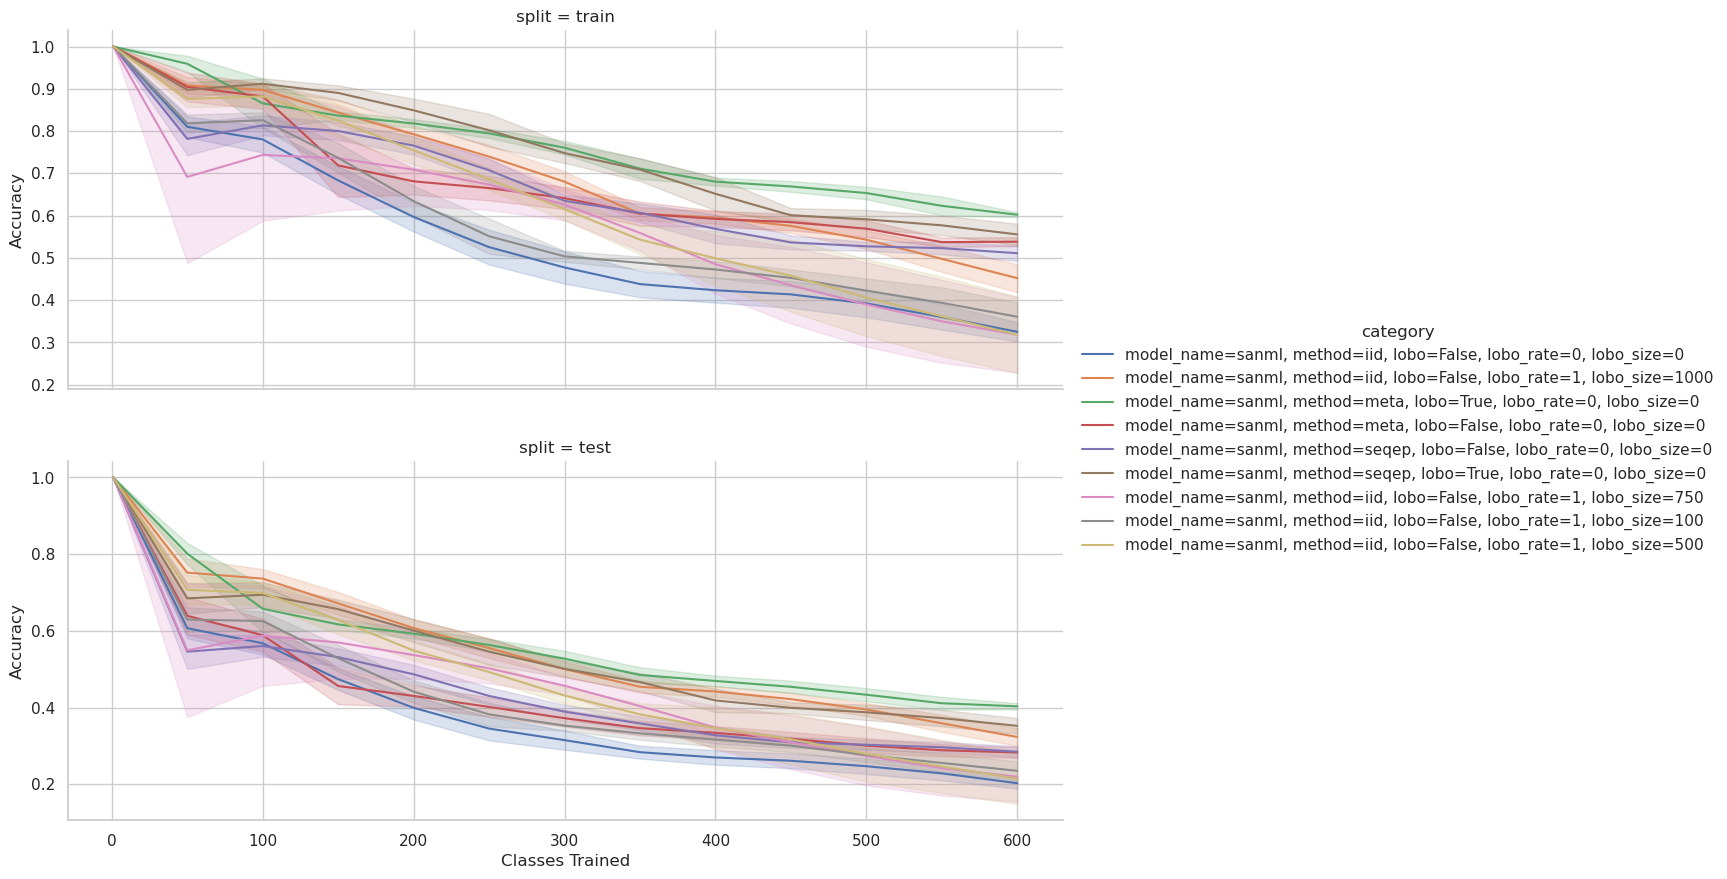

In [34]:
# Now plot them.
best_olft_df = filter_to_match_models(olft_best_lrs, best_olft_models).copy()
add_category_column(best_olft_df, group_cols)
_ = plot_traj_per_lr(best_olft_df, hue="category")

# i.i.d. Fine-Tuning Evaluation

## Unfrozen

### Best Models Per Category

In [39]:
iid_df = drop_top5_columns(all_frames["iid-unfrozen"])
iid_df = filter_by_value(iid_df, "train_dataset", "omni")
iid_overall_accuracy = combine_train_test_columns(iid_df)
iid_overall_accuracy = rename_like_models(iid_overall_accuracy)

In [40]:
iid_overall_accuracy.index.get_level_values("train_examples").unique()

Int64Index([15], dtype='int64', name='train_examples')

In [41]:
# Filter the data to the desired number of training examples.
# num_train_examples = 500
# rows = iid_overall_accuracy.index.get_level_values("train_examples") == num_train_examples
# iid_one_train_size = iid_overall_accuracy.loc[rows]

# Or, don't filter.
num_train_examples = None
iid_one_train_size = iid_overall_accuracy

# Now select one LR per pretrain group.
iid_best_lrs = select_best_lr_per_group(iid_one_train_size)

In [42]:
get_model_descriptions(iid_best_lrs)

train_dataset model_name  \
model                                                       
ablaze-ring-62-25000                      omni      sanml   
affectionate-flower-96-570                omni      sanml   
angelic-balloon-100-570                   omni      sanml   
attractive-cupid-107-570                  omni      sanml   
attractive-heartthrob-103-570             omni      sanml   
beguiling-valentine-93-570                omni      sanml   
blazing-darling-60-25000                  omni      sanml   
blazing-tulip-66-25000                    omni      sanml   
cherubic-flower-58-25000                  omni      sanml   
clear-butterfly-6227-570                  omni      sanml   
confused-disco-6224-570                   omni      sanml   
constant-violet-85-9000                   omni      sanml   
dedicated-darling-82-9000                 omni      sanml   
deeply-crush-70-25000                     omni      sanml   
deeply-sweetheart-88-9000                 omni      sanml   
dreamy-heart-71-25000                     omni      sanml   
eager-deluge-6242-570                     omni      sanml   
eager-quiver-106-570                      omni      sanml   
effusive-romance-75-9000                  omni      sanml   
enamored-crush-77-9000                    omni      sanml   
enthusiastic-candy-heart-90-9000          omni      sanml   
ethereal-water-6238-570                   omni      sanml   
glad-valley-6240-570                      omni      sanml   
hopeful-fire-6247-570                     omni      sanml   
kind-sponge-6235-570                      omni      sanml   
peachy-lake-6223-570                      omni      sanml   
spring-hill-6231-570                      omni      sanml   

                                         train_method  lobotomize  lobo_rate  \
model                                                                          
ablaze-ring-62-25000                             meta        True          0   
affectionate-flower-96-570                        iid       False          1   
angelic-balloon-100-570                           iid       False          1   
attractive-cupid-107-570                          iid       False          0   
attractive-heartthrob-103-570                     iid       False          0   
beguiling-valentine-93-570                        iid       False          1   
blazing-darling-60-25000                         meta        True          0   
blazing-tulip-66-25000                           meta       False          0   
cherubic-flower-58-25000                         meta        True          0   
clear-butterfly-6227-570                          iid       False          1   
confused-disco-6224-570                           iid       False          1   
constant-violet-85-9000           sequential_episodic       False          0   
dedicated-darling-82-9000         sequential_episodic        True          0   
deeply-crush-70-25000                            meta       False          0   
deeply-sweetheart-88-9000         sequential_episodic       False          0   
dreamy-heart-71-25000                            meta       False          0   
eager-deluge-6242-570                             iid       False          1   
eager-quiver-106-570                              iid       False          0   
effusive-romance-75-9000          sequential_episodic        True          0   
enamored-crush-77-9000            sequential_episodic        True          0   
enthusiastic-candy-heart-90-9000  sequential_episodic       False          0   
ethereal-water-6238-570                           iid       False          1   
glad-valley-6240-570                              iid       False          1   
hopeful-fire-6247-570                             iid       False          1   
kind-sponge-6235-570                              iid       False          1   
peachy-lake-6223-570                              iid       False          1   
spring-hill-6231-570   

In [43]:
# Print final accuracy per model, when fine-tuned on this number of examples.
iid_perf_per_model = get_final_perf_per_model(iid_best_lrs, num_train_examples, print_result=True)

Final accuracy on 600 classes:
          ablaze-ring-62-25000 | 67.8% (std: 0.8%)
    affectionate-flower-96-570 | 60.9% (std: 0.8%)
       angelic-balloon-100-570 | 51.9% (std: 1.1%)
      attractive-cupid-107-570 | 35.1% (std: 1.2%)
 attractive-heartthrob-103-570 | 54.4% (std: 1.0%)
    beguiling-valentine-93-570 | 66.2% (std: 0.7%)
      blazing-darling-60-25000 | 69.5% (std: 0.8%)
        blazing-tulip-66-25000 | 59.1% (std: 1.2%)
      cherubic-flower-58-25000 | 72.1% (std: 0.7%)
      clear-butterfly-6227-570 | 41.9% (std: 1.1%)
       confused-disco-6224-570 | 50.4% (std: 4.6%)
       constant-violet-85-9000 | 57.5% (std: 0.9%)
     dedicated-darling-82-9000 | 62.3% (std: 0.8%)
         deeply-crush-70-25000 | 60.0% (std: 0.8%)
     deeply-sweetheart-88-9000 | 58.5% (std: 1.2%)
         dreamy-heart-71-25000 | 49.7% (std: 0.7%)
         eager-deluge-6242-570 | 48.4% (std: 6.6%)
          eager-quiver-106-570 | 47.2% (std: 1.0%)
      effusive-romance-75-9000 | 59.7% (std: 13.0%)

In [44]:
group_cols = ["model_name", "train_method", "zap", "zap_rate", "zap_size"]
best_iid_models = get_top_model_per_group(iid_best_lrs, iid_perf_per_model, group_cols)
best_iid_models

mean  \
model_name train_method        lobotomize lobo_rate lobo_size model                                     
sanml      iid                 False      0         0         attractive-heartthrob-103-570  0.543811   
                                          1         100       peachy-lake-6223-570           0.561900   
                                                    500       spring-hill-6231-570           0.628933   
                                                    750       glad-valley-6240-570           0.625278   
                                                    1000      beguiling-valentine-93-570     0.661544   
           meta                False      0         0         deeply-crush-70-25000          0.600278   
                               True       0         0         cherubic-flower-58-25000       0.721456   
           sequential_episodic False      0         0         deeply-sweetheart-88-9000      0.584867   
                               True       0         0         enamored-crush-77-9000         0.640900   

                                                                                                  std  
model_name train_method        lobotomize lobo_rate lobo_size model                                    
sanml      iid                 False      0         0         attractive-heartthrob-103-570  0.009769  
                                          1         100       peachy-lake-6223-570           0.047954  
                                                    500       spring-hill-6231-570           0.008045  
                                                    750       glad-valley-6240-570           0.024243  
                                                    1000      beguiling-valentine-93-570     0.006806  
           meta                False      0         0         deeply-crush-70-25000          0.008401  
                               True       0         0         cherubic-flower-58-25000       0.007380  
           sequential_episodic False      0         0         deeply-sweetheart-88-9000      0.012365  
                               True       0         0         enamored-crush-77-9000         0.009844

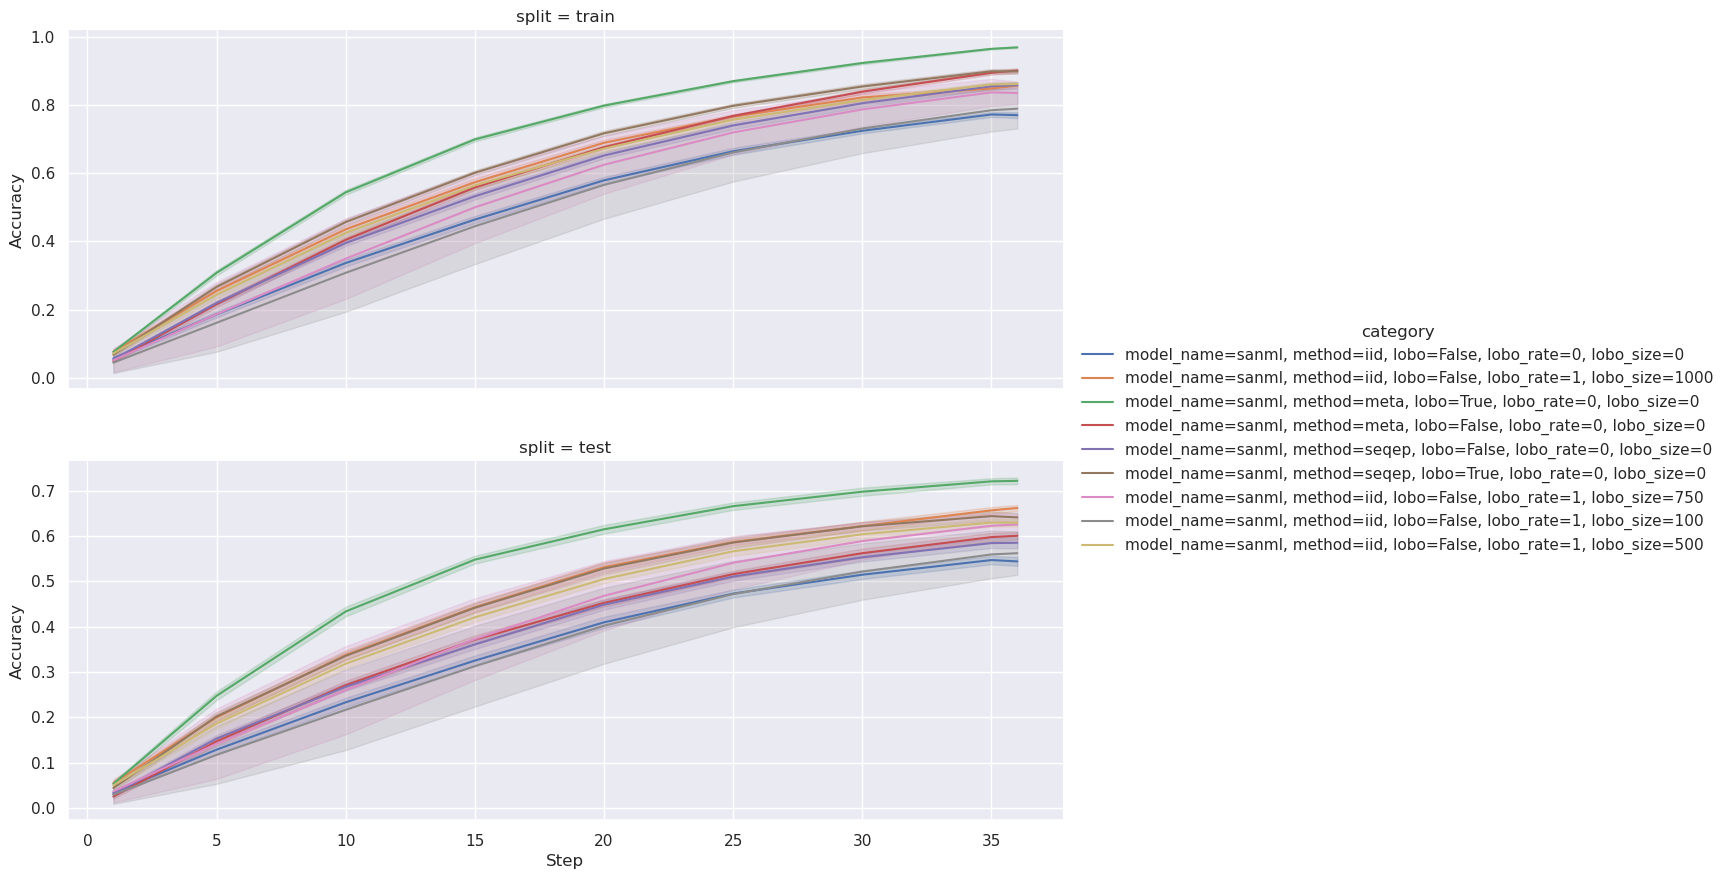

In [45]:
# Now plot them. Copy to avoid a SettingWithCopy warning.
best_iid_df = filter_to_match_models(iid_best_lrs, best_iid_models).copy()
add_category_column(best_iid_df, group_cols)
_ = plot_traj_per_lr(best_iid_df, hue="category")

# No SGD ("Zero-Shot") Results

In [151]:
zero_df = drop_top5_columns(all_frames["no-sgd"])
zero_df = filter_by_value(zero_df, "train_dataset", "omni")
z_overall_accuracy = combine_train_test_columns(zero_df)
z_overall_accuracy = rename_like_models(z_overall_accuracy)
z_overall_accuracy

accuracy
model                    train_dataset model_name train_method        lobotomize train_lr inner_lr outer_lr eval_dataset train_examples test_examples eval_method reinit_method reinit_params     classes trial seed  split          
angelic-balloon-100-570  omni          sanml      iid                 False      0.0003   0.00     0.000    omni         15             5             zero_shot   lstsq         classifier.linear 600     0     49289 train  0.996778
                                                                                                                                                                                                          1     49289 train  0.998222
                                                                                                                                                                                                          2     49289 train  0.996778
                                                                                                                                                                                                          3     49289 train  0.997111
                                                                                                                                                                                                          4     49289 train  0.996667
...                                                                                                                                                                                                                               ...
effusive-romance-75-9000 omni          sanml      sequential_episodic True       0.0000   0.01     0.001    omni         15             5             zero_shot   lstsq         classifier.linear 600     5     29384 test   0.773667
                                                                                                                                                                                                          6     29384 test   0.753333
                                                                                                                                                                                                          7     29384 test   0.759333
                                                                                                                                                                                                          8     29384 test   0.776667
                                                                                                                                                                                                          9     29384 test   0.752000

[1260 rows x 1 columns]

In [152]:
# Print final accuracy per model, when fine-tuned on this number of examples.
z_perf_per_model = get_final_perf_per_model(z_overall_accuracy, num_train_examples, print_result=True)

Final accuracy on 600 classes:
          ablaze-ring-62-25000 | 64.8% (std: 0.9%)
    affectionate-flower-96-570 | 75.1% (std: 5.4%)
       angelic-balloon-100-570 | 69.6% (std: 6.0%)
 attractive-heartthrob-103-570 | 72.8% (std: 4.5%)
      blazing-darling-60-25000 | 75.3% (std: 0.7%)
        blazing-tulip-66-25000 | 60.2% (std: 2.4%)
      cherubic-flower-58-25000 | 76.6% (std: 0.6%)
       constant-violet-85-9000 | 64.1% (std: 0.9%)
     dedicated-darling-82-9000 | 56.6% (std: 1.0%)
         deeply-crush-70-25000 | 61.9% (std: 1.8%)
     deeply-sweetheart-88-9000 | 65.0% (std: 0.9%)
         dreamy-heart-71-25000 | 48.0% (std: 2.0%)
      effusive-romance-75-9000 | 64.3% (std: 19.1%)
        enamored-crush-77-9000 | 74.3% (std: 0.7%)
enthusiastic-candy-heart-90-9000 | 52.6% (std: 1.9%)


In [153]:
_ = get_final_perf_per_model(z_overall_accuracy, num_train_examples, split="train", print_result=True)

Final accuracy on 600 classes:
          ablaze-ring-62-25000 | 99.9% (std: 0.0%)
    affectionate-flower-96-570 | 98.0% (std: 2.7%)
       angelic-balloon-100-570 | 97.5% (std: 3.4%)
 attractive-heartthrob-103-570 | 96.7% (std: 4.4%)
      blazing-darling-60-25000 | 100.0% (std: 0.0%)
        blazing-tulip-66-25000 | 99.9% (std: 0.0%)
      cherubic-flower-58-25000 | 99.9% (std: 0.0%)
       constant-violet-85-9000 | 99.9% (std: 0.0%)
     dedicated-darling-82-9000 | 100.0% (std: 0.0%)
         deeply-crush-70-25000 | 99.9% (std: 0.0%)
     deeply-sweetheart-88-9000 | 99.9% (std: 0.0%)
         dreamy-heart-71-25000 | 99.6% (std: 0.8%)
      effusive-romance-75-9000 | 86.3% (std: 22.6%)
        enamored-crush-77-9000 | 99.9% (std: 0.0%)
enthusiastic-candy-heart-90-9000 | 99.8% (std: 0.3%)


# Deep Dive Into a Single Model

/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)


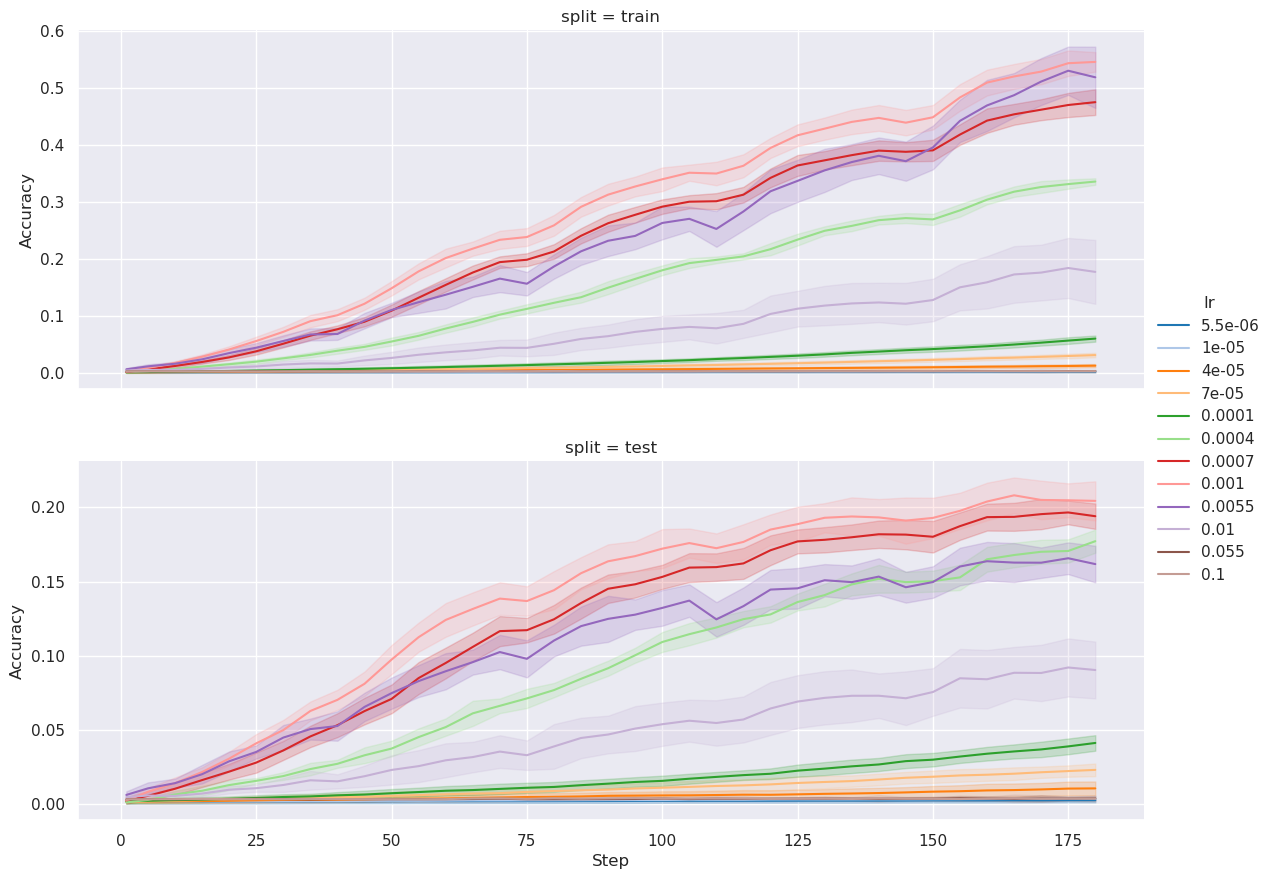

In [55]:
rows = df.index.get_level_values("model") == "glittering-snake-21-1260"
desired_rows = df.loc[rows]
fg = plot_traj_per_lr(desired_rows, palette="tab20")

/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)


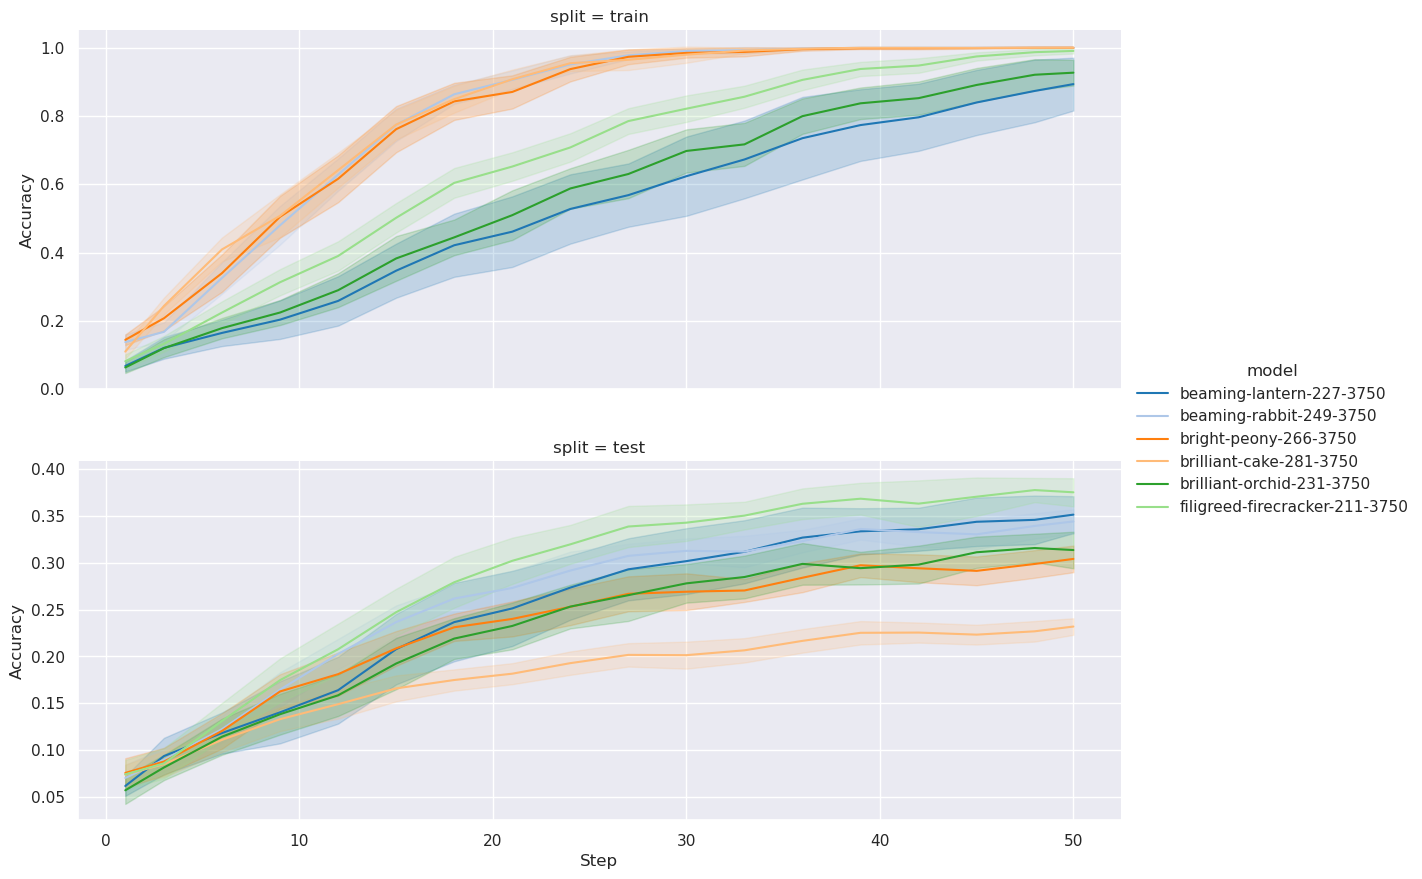

In [32]:
iid_df = maybe_filter_by_value(df, "train_method", "iid")
iid_df = select_best_lr_per_group(iid_df)
fg = plot_traj_per_lr(iid_df, palette="tab20")

/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)


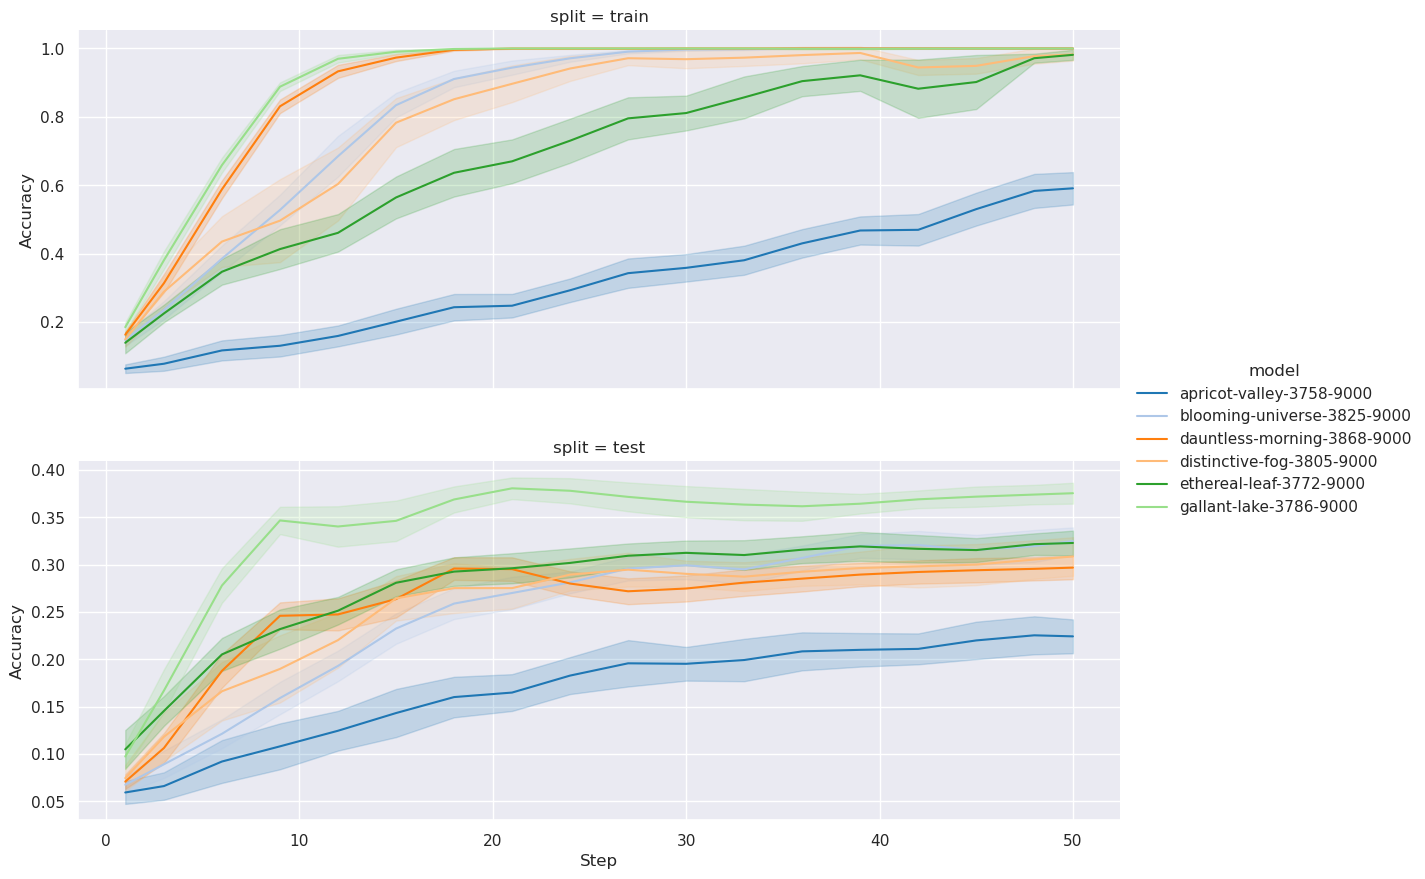

In [33]:
iid_df = maybe_filter_by_value(df, "train_method", "ASB")
iid_df = select_best_lr_per_group(iid_df)
fg = plot_traj_per_lr(iid_df, palette="tab20")

In [58]:
get_model_descriptions(iid_df)

train_dataset model_name train_method  lobotomize  \
model                                                                           
auspicious-dumpling-27-1260   omniimage20   resnet18          iid       False   
beaming-rabbit-47-1260        omniimage20      sanml          iid       False   
brilliant-pig-60-1260         omniimage20      sanml          iid       False   
glittering-pig-24-1260        omniimage20   resnet18          iid       False   
glittering-snake-21-1260      omniimage20   resnet18          iid       False   
golden-festival-79-1260       omniimage20      sanml          iid       False   

                             train_lr  inner_lr  outer_lr   seed  
model                                                             
auspicious-dumpling-27-1260    0.0003       0.0       0.0  29384  
beaming-rabbit-47-1260         0.0030       0.0       0.0  29384  
brilliant-pig-60-1260          0.0010       0.0       0.0  29384  
glittering-pig-24-1260         0.0010       0.0       0.0  29384  
glittering-snake-21-1260       0.0030       0.0       0.0  29384  
golden-festival-79-1260        0.0003       0.0       0.0  29384

# Sensitivity to Learning Rate (Deprecated)

This section has not yet been updated to conform to the new dataframe format.

CPU times: user 2.2 s, sys: 59.4 ms, total: 2.26 s
Wall time: 3.35 s


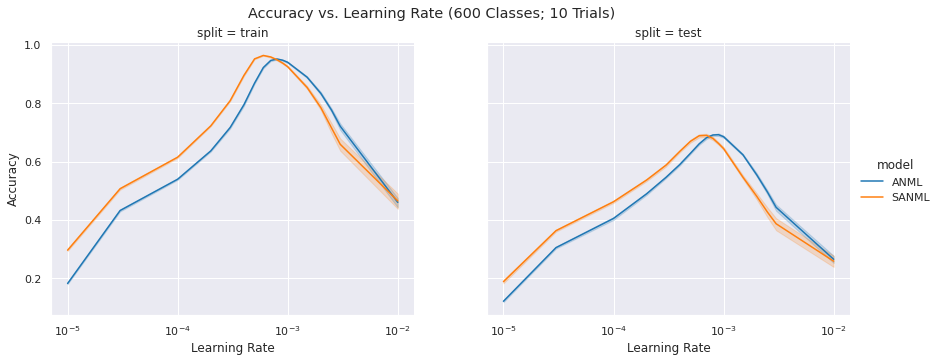

In [52]:
%%time

import warnings
from numbers import Number

# We want to plot the result of learning this number of classes across different choices of learning rate.
def plot_perf_vs_learning_rate(df, num_classes_learned, lr_range=None):

    # Filter down to just the slice that has learned this many classes.
    if isinstance(num_classes_learned, Number):
        # Convert to list of numbers first.
        num_classes_learned = [num_classes_learned]
    classes_trained = df.index.get_level_values("classes_trained")
    df = df.loc[classes_trained.map(lambda x: x in num_classes_learned), :]
    
    # Filter to only the desired learning rates.
    if lr_range:
        assert len(lr_range) == 2
        lrs = df.index.get_level_values("lr")
        rows = (lrs >= lr_range[0]) & (lrs <= lr_range[1])
        df = df.loc[rows, :]        
    
    # We want to make sure we are not accidentally aggregating across runs with different configs.
    ensure_unique(df, ["eval_dataset", "num_test_examples"])
    # Only add more levels of nesting if needed.
    hue = None
    if df.index.get_level_values("model").nunique() > 1:
        hue = "model"
    style = None
    nte = df.index.get_level_values("num_train_examples")
    ct = df.index.get_level_values("classes_trained")
    if nte.nunique() > 1 and ct.nunique() > 1:
        # We can't have both of these at once.
        raise RuntimeError("Cannot show multiple values of both 'num_train_examples' and 'classes_trained'.")
    elif ct.nunique() > 1:
        style = "classes_trained"
    elif nte.nunique() > 1:
        style = "num_train_examples"

    # Temporarily suppress this annoying and unnecessary warning coming from Seaborn.
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*not compatible with tight_layout.*")
        fg = sns.relplot(
            data=df,
            x="lr",
            y="accuracy",
            col="split",
            hue=hue,
            style=style,
            palette="tab10",
            kind="line",
            #ci="sd",  # Remove this to plot 95% CI instead. It will take a long time.
            aspect=1.3,
            facet_kws=dict(gridspec_kws=dict(top=0.88))
        )
    # Adjust labels.
    ntrials = df.index.get_level_values("trial").nunique()
    fg.set(xscale="log")
    cls_text = ""
    if len(num_classes_learned) == 1:
        cls_text = f"{num_classes_learned[0]} Classes; "
    fg.figure.suptitle(f"Accuracy vs. Learning Rate ({cls_text}{ntrials} Trials)")
    fg.set_axis_labels("Learning Rate", "Accuracy")


# Determine which point(s) on the learning trajectories to plot.
num_classes = [600]
# Now do the plotting.
plot_perf_vs_learning_rate(olft_overall_accuracy, num_classes)#, lr_range=(float("-inf"), 0.03))

# Launching Additional Evals

This section is used for scanning existing models and launching jobs to evaluate them if they are missing a particular flavor of evaluation.

Define some functions and imports up front which will be used by multiple different cells.

In [65]:
best_checkpoints = find_best_checkpoints(train_config_files)
all_eval_folders = scan_for_eval_folders(best_checkpoints)


Found a total of 543 models to compare.
0 models were excluded from the eval index.


In [35]:
import launch_eval_map as evaljob
from utils import ensure_config_param, update_with_keys
from utils.logging import check_eval_config


def num_results(folder):
    return len(list(folder.glob("*.pkl")))


def has_any_eval_data(folder):
    return num_results(folder) > 0


def num_expected_results(folder):
    argfiles = list(folder.glob("args*.txt"))
    # We must take the maximum of all argfiles because subsequent runs might have fewer than the total.
    num_expected = 1
    for argfile in argfiles:
        with open(argfile) as af:
            numlines = len(af.readlines())
            num_expected = max(num_expected, numlines)
    return num_expected


def num_results_missing(folder):
    num_data_files = num_results(folder)
    num_expected = num_expected_results(folder)
    if num_data_files > num_expected:
        print(f"WARNING: {folder.parent.name} has more files ({num_data_files}) than expected ({num_expected}).")
    return num_expected - num_data_files


def has_all_eval_data(folder):
    return num_results_missing(folder) <= 0


def get_flavor_config(train_cfg, target_flavor):
    cfg_list = train_cfg["eval"]
    if not isinstance(cfg_list, list):
        cfg_list = [cfg_list]
    for eval_cfg in cfg_list:
        # If the config only has one key, then this names the "flavor" of the evaluation, and the corresponding
        # value is actually the config.
        if len(eval_cfg) == 1:
            flavor, eval_cfg = next(iter(eval_cfg.items()))
            if flavor == target_flavor:
                return eval_cfg
    raise RuntimeError(f'Could not find flavor "{target_flavor}" in the training config.')


def get_configs_for_eval(eval_folder):
    # NOTE: Assumes one config per folder.
    eval_cfg = load_yaml(next(iter(eval_folder.glob("eval-config-*.yml"))))
    train_cfg = train_configs[eval_folder.parent.stem]
    return train_cfg, eval_cfg


def get_prepared_configs_for_eval(flavor, eval_folder):
    train_cfg, disk_eval_cfg = get_configs_for_eval(eval_folder)

    # Instead of loading the eval config from the folder, we are taking it from the train config. This is because
    # the version in the eval folder has already been split up into multiple sub-jobs.
    eval_cfg = get_flavor_config(train_cfg, flavor)
    eval_cfg = eval_cfg.copy()  # copy before editing
    eval_cfg["model"] = disk_eval_cfg["model"]
    update_with_keys(train_cfg, eval_cfg, ["project", "entity", "group", "model_name", "train_method"])
    eval_cfg.setdefault("group", disk_eval_cfg.get("group"))

    check_eval_config(eval_cfg)
    return train_cfg, eval_cfg


def get_eval_config_for_model(train_cfg, model_file, flavor):
    """Extracts the given eval flavor config from the train config, and points it to the given model."""
    eval_cfg = get_flavor_config(train_cfg, flavor)
    eval_cfg = eval_cfg.copy()  # copy before editing
    eval_cfg["model"] = str(model_file)
    update_with_keys(train_cfg, eval_cfg, ["project", "entity", "group", "model_name", "train_method"])

    check_eval_config(eval_cfg)
    return eval_cfg


The first cell below is just for printing info about missing data.

In [66]:
# flavors_of_interest = ["no-sgd", "unfrozen", "olft", "iid-unfrozen", "iid-unfrozen-5epochs",
#                        "iid-unfrozen-5epochs-omniglot"]
flavors_of_interest = ["no-sgd", "unfrozen", "olft", "iid-unfrozen-5epochs"]#, "iid-unfrozen"]
total = len(all_eval_folders)
total_flavors_of_interest = 0
total_flavors_incomplete = 0
total_expected_data = 0
total_missing_data = 0
skipped = 0
for i, (name, eval_folders) in enumerate(all_eval_folders.items()):
    train_cfg = train_configs[name]
    if train_cfg["dataset"] == "imagenet84" or train_cfg.get("imgs_per_class") == 100:
        skipped += 1
        continue

    #print(f"({i+1}/{total}) Scanning {len(eval_folders)} evaluations for {name}...")
    for f in eval_folders:
        check_flavor = (not flavors_of_interest) or (flavor_from_folder(f) in flavors_of_interest)
        if check_flavor:
            total_flavors_of_interest += 1
            num_data_files = num_results(f)
            num_expected = num_expected_results(f)
            num_missing = num_expected - num_data_files
            total_missing_data += num_missing
            total_expected_data += num_expected
            if num_missing > 0:
                total_flavors_incomplete += 1
                train_dataset = train_cfg["dataset"]
                model = train_cfg["model_name"]
                print(f"{name:25} {train_dataset:13} {model:10} {flavor_from_folder(f):31} expected {num_expected:2} but found {num_data_files:2}.")
            if num_data_files > num_expected:
                print(f"WARNING: {f.parent.stem} has more files ({num_data_files}) than expected ({num_expected}).")

print(f"\nSkipped {skipped} models.")
print(f"{total_flavors_incomplete}/{total_flavors_of_interest}"
      f" ({total_flavors_incomplete/total_flavors_of_interest:.1%}) of flavors are incomplete.")
print(f"{total_missing_data}/{total_expected_data}"
      f" ({total_missing_data/total_expected_data:.1%}) of all data is missing.")

silvery-mountain-39       omniimage     resnet18   iid-unfrozen-5epochs            expected  7 but found  6.

Skipped 54 models.
1/1956 (0.1%) of flavors are incomplete.
1/14536 (0.0%) of all data is missing.


This next cell relaunches an existing flavor from the training config if it's missing data. But it will only find flavors with existing folders (it relies on the folder to identify which checkpoint it should run). See a few cells below for something that will fill in _any_ missing results from any training config.

In [56]:

def relaunch_existing_eval(flavor, eval_folder, cluster=None, dry_run=False):
    train_cfg, eval_cfg = get_prepared_configs_for_eval(flavor, eval_folder)
    if cluster is None:
        cluster = train_cfg["cluster"]

    retcode = evaljob.launch(eval_cfg, flavor=flavor, cluster=cluster, launcher_args=["--mem=12G"], force=True,
                             keep_existing_outputs=True, dry_run=dry_run)
    if retcode != 0:
        print(f"WARNING: Eval job may not have launched. Launcher exited with code {retcode}. See above for"
              " possible errors.")
    return retcode


desired_flavor = "olft"
cluster = "bdgpu"

# Iterate over all models.
total = len(all_eval_folders)
num_launched = 0
num_failures = 0
for name, eval_folders in all_eval_folders.items():
    available_flavors = [flavor_from_folder(f) for f in eval_folders]
    try:
        flavdex = available_flavors.index(desired_flavor)
        flav_folder = eval_folders[flavdex]
        if not has_all_eval_data(flav_folder):
            print(f"Data is missing from {name}.")
            retcode = relaunch_existing_eval(desired_flavor, flav_folder, cluster, False)
            print()
            if retcode == 0:
                num_launched += 1
            else:
                num_failures += 1
    except ValueError:
        continue

print(f"Launched a total of {num_launched} jobs.")
if num_failures > 0:
    print(f"WARNING: {num_failures} jobs failed to launch. See the logs above for more info.")

Data is missing from wise-dawn-80.
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/wise-dawn-80/eval-classifier-1405-olft --mem=12G /gpfs2/scratch/ntraft/Development/higherANML/eval_map.py --config /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/wise-dawn-80/eval-classifier-1405-olft/eval-config-1335828d6b6848549473bc3727237c2e.yml --data-path /gpfs2/scratch/ntraft/Development/higherANML/experiments/data --output /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/wise-dawn-80/eval-classifier-1405-olft/gpfs2-scratch-ntraft-Development-higherANML-experiments-monster-wise-dawn-80-trained_anmls-classifier-3-84-84-1405.net-omniimage-300-15-5-7e-05.pkl --lr 7e-05
Submitted batch job 12279997

Launched a total of 1 jobs.


This next cell launches a new flavor, which wasn't in the original training config, unless it already exists _and_ has complete results (will only re-run missing results).

In [67]:

def launch_new_eval(orig_flavor, eval_folder, new_flavor, modifications, cluster=None, dry_run=False):
    train_cfg, eval_cfg = get_prepared_configs_for_eval(orig_flavor, eval_folder)
    eval_cfg.update(modifications)
    if cluster is None:
        cluster = train_cfg["cluster"]

    retcode = evaljob.launch(eval_cfg, flavor=new_flavor, cluster=cluster, launcher_args=["--mem=12G"], force=True,
                             keep_existing_outputs=True, dry_run=dry_run)
    if retcode != 0:
        print(f"WARNING: Eval job may not have launched. Launcher exited with code {retcode}. See above for"
              " possible errors.")


def matches_dataset(name, train_dataset, imgs_per_class):
    if not train_dataset:
        return True
    train_cfg = train_configs[name]
    return train_cfg["dataset"] == train_dataset and train_cfg.get("imgs_per_class") == imgs_per_class
    

# train_dataset = "omni"
# imgs_per_class = None
# train_dataset = "miniimagenet"
# imgs_per_class = None
train_dataset = "omniimage"
imgs_per_class = 20

cluster = "bdgpu"

orig_flavor = "iid-unfrozen"
new_flavor = "iid-unfrozen-5epochs"
modifications = {
    "epochs": 5,
}

# orig_flavor = "unfrozen"
# new_flavor = "olft"
# modifications = {
#     "opt_params": "classifier",
# }

# orig_flavor = "iid-unfrozen"
# new_flavor = "iid-unfrozen-5epochs-omniglot"
# modifications = {
#     "dataset": "omni",
#     "greyscale": False,
#     "im_size": 84,
#     "imgs_per_class": None,
#     "train_examples": 15,
#     "test_examples": 5,
#     "classes": 600,
#     "epochs": 5,
#     "eval_freq": 5,
# }

# Iterate over all models.
total = len(all_eval_folders)
count = 0
err_count = 0
for name, eval_folders in all_eval_folders.items():
    available_flavors = [flavor_from_folder(f) for f in eval_folders]
    has_new_flavor = False
    try:
        new_folder = eval_folders[available_flavors.index(new_flavor)]
        if has_all_eval_data(new_folder):
            has_new_flavor = True
    except ValueError:
        pass

    if has_new_flavor:
        continue

    try:
        flavdex = available_flavors.index(orig_flavor)
        orig_folder = eval_folders[available_flavors.index(orig_flavor)]
    except ValueError:
        print(f"\nERROR: Cannot launch for {name} because the original flavor is missing!")
        err_count += 1
        continue

    if matches_dataset(name, train_dataset, imgs_per_class):
        print(f"\nLaunching eval for {name}...")
        launch_new_eval(orig_flavor, orig_folder, new_flavor, modifications, cluster, False)
        count += 1

print(f"\nLaunched a total of {count} jobs.")
if err_count:
    print(f"Encountered {err_count} missing flavors (see log above).")


Launching eval for silvery-mountain-39...
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/silvery-mountain-39/eval-classifier-25000-iid-unfrozen-5epochs --mem=12G /gpfs2/scratch/ntraft/Development/higherANML/eval_map.py --config /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/silvery-mountain-39/eval-classifier-25000-iid-unfrozen-5epochs/eval-config-b94eaddc752d49c9abb5ca54940a4b7c.yml --data-path /gpfs2/scratch/ntraft/Development/higherANML/experiments/data --output /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/silvery-mountain-39/eval-classifier-25000-iid-unfrozen-5epochs/gpfs2-scratch-ntraft-Development-higherANML-experiments-monster-silvery-mountain-39-trained_anmls-classifier-3-84-84-25000.net-omniimage-300-15-5-5-0.001.pkl --lr 0.001
Submitted batch job 12280106

Launched a total of 1 jobs.


Here we find checkpoints that were not included in the scanned folders and try to fill in their missing no-sgd data. Otherwise they are invisible to the rest of this notebook.

In [28]:
cluster = "bdgpu"

total = len(all_eval_folders)
num_launched = 0
num_failures = 0
missing_eval_folders = []
for name, f in train_config_files.items():
    pdir = f.parent
    # First check for folders just ending with "no-sgd".
    no_sgd_evals = list(pdir.glob("eval-*-no-sgd"))
    if not no_sgd_evals:
        # If we don't find "no-sgd", there might be multiple and we should find the "large" one.
        no_sgd_evals = list(pdir.glob("eval-*-no-sgd-*-lg"))
        if not no_sgd_evals:
            print(f"WARNING: Could not find any no-SGD folder for {name}.")
            continue
            # If you want to debug this condition, uncomment the following line:
            # print(f"Files: {[f.name for f in pdir.iterdir()]}")

    # Record folders which are missing data.
    for flav_folder in no_sgd_evals:
        if not has_all_eval_data(flav_folder):
            print(f"Data is missing from {name}/{flav_folder.name}.")
            retcode = relaunch_existing_eval("no-sgd", flav_folder, cluster, False)
            print()
            if retcode == 0:
                num_launched += 1
            else:
                num_failures += 1

print(f"Launched a total of {num_launched} jobs.")
if num_failures > 0:
    print(f"WARNING: {num_failures} jobs failed to launch. See the logs above for more info.")

Data is missing from amber-glade-55/eval-classifier-3895-no-sgd.
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/amber-glade-55/eval-classifier-3895-no-sgd --mem=12G /gpfs2/scratch/ntraft/Development/higherANML/eval_map.py --config /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/amber-glade-55/eval-classifier-3895-no-sgd/eval-config-03da6b3f4dda426f8ffa9544300f21bc.yml --data-path /gpfs2/scratch/ntraft/Development/higherANML/experiments/data --output /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/amber-glade-55/eval-classifier-3895-no-sgd/gpfs2-scratch-ntraft-Development-higherANML-experiments-monster-amber-glade-55-trained_anmls-classifier-3-84-84-3895.net-miniimagenet-20-30-100.pkl
Submitted batch job 12265962

Data is missing from ancient-water-79/eval-classifier-1405-no-sgd.
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/ancient-water-79/

Submitted batch job 12265972

Data is missing from comfy-darkness-27/eval-classifier-615-no-sgd.
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/comfy-darkness-27/eval-classifier-615-no-sgd --mem=12G /gpfs2/scratch/ntraft/Development/higherANML/eval_map.py --config /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/comfy-darkness-27/eval-classifier-615-no-sgd/eval-config-37256e3d18a04998a0742c1a63c48784.yml --data-path /gpfs2/scratch/ntraft/Development/higherANML/experiments/data --output /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/comfy-darkness-27/eval-classifier-615-no-sgd/gpfs2-scratch-ntraft-Development-higherANML-experiments-monster-comfy-darkness-27-trained_anmls-classifier-1-28-28-615.net-omni-600-15-5.pkl
Submitted batch job 12265973

Data is missing from cosmic-sunset-39/eval-classifier-3837-no-sgd.
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experi

Submitted batch job 12265983

Data is missing from different-monkey-65/eval-classifier-1347-no-sgd.
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/different-monkey-65/eval-classifier-1347-no-sgd --mem=12G /gpfs2/scratch/ntraft/Development/higherANML/eval_map.py --config /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/different-monkey-65/eval-classifier-1347-no-sgd/eval-config-ae2042692a0844cba7eb04072ec9bfc4.yml --data-path /gpfs2/scratch/ntraft/Development/higherANML/experiments/data --output /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/different-monkey-65/eval-classifier-1347-no-sgd/gpfs2-scratch-ntraft-Development-higherANML-experiments-monster-different-monkey-65-trained_anmls-classifier-3-84-84-1347.net-omniimage-300-15-5.pkl
Submitted batch job 12265984

Data is missing from different-moon-76/eval-classifier-1405-no-sgd.
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Developm

Submitted batch job 12265993

Data is missing from fanciful-water-15/eval-classifier-597-no-sgd.
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/fanciful-water-15/eval-classifier-597-no-sgd --mem=12G /gpfs2/scratch/ntraft/Development/higherANML/eval_map.py --config /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/fanciful-water-15/eval-classifier-597-no-sgd/eval-config-c45cac295a0049d1abdc6a23fdb27704.yml --data-path /gpfs2/scratch/ntraft/Development/higherANML/experiments/data --output /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/fanciful-water-15/eval-classifier-597-no-sgd/gpfs2-scratch-ntraft-Development-higherANML-experiments-monster-fanciful-water-15-trained_anmls-classifier-1-28-28-597.net-omni-600-15-5.pkl
Submitted batch job 12265994

Data is missing from fine-serenity-5/eval-classifier-579-no-sgd.
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experime

Submitted batch job 12266004

Data is missing from likely-wildflower-21/eval-classifier-615-no-sgd.
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/likely-wildflower-21/eval-classifier-615-no-sgd --mem=12G /gpfs2/scratch/ntraft/Development/higherANML/eval_map.py --config /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/likely-wildflower-21/eval-classifier-615-no-sgd/eval-config-e75f9f073fc1498d8664d7864c9e8e4b.yml --data-path /gpfs2/scratch/ntraft/Development/higherANML/experiments/data --output /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/likely-wildflower-21/eval-classifier-615-no-sgd/gpfs2-scratch-ntraft-Development-higherANML-experiments-monster-likely-wildflower-21-trained_anmls-classifier-1-28-28-615.net-omni-600-15-5.pkl
Submitted batch job 12266005

Data is missing from logical-rain-17/eval-classifier-597-no-sgd.
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/high

Submitted batch job 12266015

Data is missing from rose-blaze-13/eval-classifier-597-no-sgd.
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/rose-blaze-13/eval-classifier-597-no-sgd --mem=12G /gpfs2/scratch/ntraft/Development/higherANML/eval_map.py --config /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/rose-blaze-13/eval-classifier-597-no-sgd/eval-config-bce938d632104cb78e418879d4c24ff5.yml --data-path /gpfs2/scratch/ntraft/Development/higherANML/experiments/data --output /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/rose-blaze-13/eval-classifier-597-no-sgd/gpfs2-scratch-ntraft-Development-higherANML-experiments-monster-rose-blaze-13-trained_anmls-classifier-1-28-28-597.net-omni-600-15-5.pkl
Submitted batch job 12266016

Data is missing from rural-fog-43/eval-classifier-3837-no-sgd.
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/rural-fog-

Submitted batch job 12266026

Data is missing from summer-disco-3/eval-classifier-579-no-sgd.
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/summer-disco-3/eval-classifier-579-no-sgd --mem=12G /gpfs2/scratch/ntraft/Development/higherANML/eval_map.py --config /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/summer-disco-3/eval-classifier-579-no-sgd/eval-config-791db4f9e95e445582977b112a8dde6d.yml --data-path /gpfs2/scratch/ntraft/Development/higherANML/experiments/data --output /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/summer-disco-3/eval-classifier-579-no-sgd/gpfs2-scratch-ntraft-Development-higherANML-experiments-monster-summer-disco-3-trained_anmls-classifier-1-28-28-579.net-omni-600-15-5.pkl
Submitted batch job 12266027

Data is missing from toasty-cherry-52/eval-classifier-3895-no-sgd.
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/t

Submitted batch job 12266037

Data is missing from worthy-river-41/eval-classifier-3837-no-sgd.
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/worthy-river-41/eval-classifier-3837-no-sgd --mem=12G /gpfs2/scratch/ntraft/Development/higherANML/eval_map.py --config /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/worthy-river-41/eval-classifier-3837-no-sgd/eval-config-c136f9eca93945279be36b41df05148e.yml --data-path /gpfs2/scratch/ntraft/Development/higherANML/experiments/data --output /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/worthy-river-41/eval-classifier-3837-no-sgd/gpfs2-scratch-ntraft-Development-higherANML-experiments-monster-worthy-river-41-trained_anmls-classifier-3-84-84-3837.net-miniimagenet-20-30-100.pkl
Submitted batch job 12266038

Data is missing from woven-dust-44/eval-classifier-3837-no-sgd.
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/exper

Here we print _all_ models which do not have a particular type of evaluation folder.

In [42]:
# flavors_of_interest = ["no-sgd", "unfrozen", "olft", "iid-unfrozen", "iid-unfrozen-5epochs",
#                        "iid-unfrozen-5epochs-omniglot"]
flavors_of_interest = ["no-sgd", "unfrozen", "olft", "iid-unfrozen"]
total = len(all_eval_folders)
total_flavors_of_interest = 0
total_missing_flavors = 0
skipped = 0
for i, (name, eval_folders) in enumerate(all_eval_folders.items()):
    train_cfg = train_configs[name]
    train_dataset = train_cfg["dataset"]
    if train_dataset == "imagenet84" or train_cfg.get("imgs_per_class") == 100:
        skipped += 1
        continue
    total_flavors_of_interest += len(flavors_of_interest)
    present_flavors = [flavor_from_folder(f) for f in eval_folders]
    for flavor in flavors_of_interest:
        if flavor not in present_flavors:
            total_missing_flavors += 1
            model = train_cfg["model_name"]
            print(f"Missing:   {name:25} {train_dataset:13} {model:10} {flavor:31}")

print(f"\nSkipped {skipped} models.")
print(f"{total_missing_flavors}/{total_flavors_of_interest}"
      f" ({total_missing_flavors/total_flavors_of_interest:.1%}) of desired flavors are missing.")

Missing:   amber-glade-55            miniimagenet  sanml      unfrozen                       
Missing:   amber-glade-55            miniimagenet  sanml      olft                           
Missing:   amber-glade-55            miniimagenet  sanml      iid-unfrozen                   
Missing:   bright-voice-54           miniimagenet  sanml      unfrozen                       
Missing:   bright-voice-54           miniimagenet  sanml      iid-unfrozen                   
Missing:   dark-aardvark-72          omniimage     sanml      iid-unfrozen                   
Missing:   dauntless-flower-63       omniimage     sanml      unfrozen                       
Missing:   dauntless-flower-63       omniimage     sanml      iid-unfrozen                   
Missing:   different-monkey-65       omniimage     sanml      iid-unfrozen                   
Missing:   dulcet-resonance-70       omniimage     sanml      unfrozen                       
Missing:   dulcet-resonance-70       omniimage     sanml    

Here we find try to fill in all those flavors which _should_ exist according to their `train-config.yml` but for which there is no folder. This only runs evaluations of the _final_ checkpoint. (We do not bother with flavors that have a folder, but the results are incomplete; in this case we only care about folders which are missing entirely.)

In [52]:

def launch_missing_eval(train_cfg, model_file, flavor, cluster=None, dry_run=False):
    eval_cfg = get_eval_config_for_model(train_cfg, model_file, flavor)
    if cluster is None:
        cluster = train_cfg["cluster"]

    retcode = evaljob.launch(eval_cfg, flavor=flavor, cluster=cluster, launcher_args=["--mem=12G"], force=True,
                             keep_existing_outputs=True, dry_run=dry_run)
    if retcode != 0:
        print(f"WARNING: Eval job may not have launched. Launcher exited with code {retcode}. See above for"
              " possible errors.")
    return retcode


cluster = "bdgpu"

# Compile a pattern to extract model info ahead of time. We expect a pattern like "name-C-W-H-checkpoint.net".
net_pattern = re.compile(r"(.*)-[0-9]+-[0-9]+-[0-9]+-([0-9]+).net")

total = len(all_eval_folders)
num_launched = 0
num_failures = 0
missing_eval_folders = []
for name, f in train_config_files.items():
    pdir = f.parent
    train_cfg = train_configs[name]
    
    # Find the final model.
    model_name = None
    model_num = 0
    model_file = None
    all_models = list((pdir / "trained_anmls").glob("*.net"))
    for model in all_models:
        match = net_pattern.fullmatch(model.name)
        # Just save info on the latest checkpoint we find.
        if int(match.group(2)) > model_num:
            model_name = match.group(1)
            model_num = int(match.group(2))
            model_file = model
    
    if model_num == 0:
        print(f"Unable to find a trained model for {name}.")
        continue
    
    # Now determine if any flavors are missing for that checkpoint, and relaunch them.
    for flavor_dict in train_cfg["eval"]:
        for flavor in flavor_dict:  # should only be one flavor here but easiest to write as a loop.
            flav_folder = pdir / f"eval-{model_name}-{model_num}-{flavor}"
            if not flav_folder.is_dir():
                print(f"Missing: {name} {flavor} {model_name+'-'+str(model_num)}")
                retcode = launch_missing_eval(train_cfg, model_file, flavor, cluster, False)
                print()
                if retcode == 0:
                    num_launched += 1
                else:
                    num_failures += 1

print(f"Launched a total of {num_launched} jobs.")
if num_failures > 0:
    print(f"WARNING: {num_failures} jobs failed to launch. See the logs above for more info.")

Missing: toasty-cherry-52 no-sgd classifier-3895
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/toasty-cherry-52/eval-classifier-3895-no-sgd --mem=12G /gpfs2/scratch/ntraft/Development/higherANML/eval_map.py --config /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/toasty-cherry-52/eval-classifier-3895-no-sgd/eval-config-abfadedcdba74403a3fa7ae987ad2603.yml --data-path /gpfs2/scratch/ntraft/Development/higherANML/experiments/data --output /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/toasty-cherry-52/eval-classifier-3895-no-sgd/gpfs2-scratch-ntraft-Development-higherANML-experiments-monster-toasty-cherry-52-trained_anmls-classifier-3-84-84-3895.net-miniimagenet-20-30-100.pkl
Submitted batch job 12278546

Missing: toasty-cherry-52 olft classifier-3895
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/toasty-cherry-52/eval-classifier-3895-olft --

# Scratch Space

In [206]:
20470 / 2

10235.0